# Final Examination 

## Python Libraries and Custom Function Setup

In [346]:
# Importing Necessary libraries
import math
import re
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import polars as pl
import seaborn as sns
import statsmodels.api as sm
import statsmodels.graphics.gofplots as gof
import xgboost as xgb
from feature_engine.encoding import OneHotEncoder, OrdinalEncoder
from feature_engine.imputation import MeanMedianImputer

# the search algorithms
from hyperopt import anneal, fmin, hp, rand, tpe
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.pipeline import make_pipeline
from imblearn.under_sampling import AllKNN, NearMiss, RandomUnderSampler, TomekLinks
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats
from scipy.stats import (
    chi2_contingency,
    chisquare,
    mannwhitneyu,
    norm,
    poisson,
    ttest_1samp,
    ttest_ind,
    wilcoxon,
)
from sklearn.cluster import DBSCAN, AgglomerativeClustering, KMeans
from sklearn.ensemble import (
    GradientBoostingClassifier,
    GradientBoostingRegressor,
    RandomForestClassifier,
    RandomForestRegressor,
)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    RocCurveDisplay,
    accuracy_score,
    confusion_matrix,
    f1_score,
    mean_absolute_error,
    mean_squared_error,
    precision_score,
    r2_score,
    recall_score,
    roc_auc_score,
    root_mean_squared_error,
    silhouette_score,
)
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, SVR
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from statsmodels.formula.api import ols
from statsmodels.stats import outliers_influence as sm_oi
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.descriptivestats import sign_test
from statsmodels.stats.proportion import proportions_ztest
from yellowbrick.cluster import SilhouetteVisualizer
from yellowbrick.model_selection import FeatureImportances, ValidationCurve
from yellowbrick.regressor import PredictionError, ResidualsPlot
from yellowbrick.target import FeatureCorrelation

sns.set_theme("notebook", style="whitegrid")
warnings.filterwarnings("ignore")

In [347]:
## Custom Functions created by mallesham yamulla
def cols_tidy(df_cols):
    df_cols_tidy = []
    for item in df_cols:
        x = re.sub(r" +", " ", item)
        x1 = re.sub(r"\,|\)|\(|\.|\-|\'", "", x)
        x2 = re.sub(r"\/", "_or_", x1)
        x3 = re.sub(r"\&", "_and_", x2)
        x4 = re.sub(r"\s(?=\_{1,})|(\_(?=\s{1,}))|\,", "", x3)
        x5 = re.sub(r" {2,}", " ", x4)
        x6 = re.sub(r"\s", "_", x5)
        x7 = re.sub(r"\:", "", x6)
        df_cols_tidy.append(x7.lower())
    return df_cols_tidy


def calculate_center_line(data, column_name):
    """Calculates the center line for the control chart."""
    return data[column_name].mean()


def calculate_control_limits(center, average_defects_per_unit, multiplier):
    """Calculates upper and lower control limits."""
    std_dev = np.sqrt(average_defects_per_unit)
    upper_limit = center + multiplier * std_dev
    lower_limit = center - multiplier * std_dev
    return upper_limit, lower_limit


def create_run_chart(data, column_name):
    """Creates a run chart for the given data."""
    plt.figure(figsize=(25, 6))
    plt.plot(data.index, data[column_name], marker="o", linestyle="-")
    plt.xlabel(
        "Projects-From Jan to Dec-2023"
    )  # Assuming the index represents time periods
    plt.ylabel(column_name)  # Replace with the actual column name
    plt.title("Run Chart for " + column_name)
    plt.grid(True)
    plt.show()


def get_hypothesis(_p_val):
    if _p_val < 0.05:
        print(
            f"P-Value:{round(_p_val,5)} is less than 0.05 hence we can reject the null hypothesis in favor of alternative hypothesis"
        )
    else:
        print(
            f"P-Value:{round(_p_val,5)} is greater than 0.05 hence we failed to reject the null hypothesis."
        )


def custom_ols_qqplot(_resid):
    """Q-Q Plot of residuals"""
    gof.qqplot(_resid, line="s")
    plt.xlabel("Standard Normal Quantiles")
    plt.ylabel("Standardized Residuals")
    plt.title("Normal Q-Q plot")
    plt.show()


def custom_ols_res_vs_fitted(_fitted, _resid):
    """Fitted Vs Residuals Plot"""
    plt.scatter(_fitted, _resid)
    plt.axhline("0", color="r")
    plt.xlabel("Fitted Values")
    plt.ylabel("Residual")
    plt.title("Residual Vs Fitted")


def custom_VIF(_MSPEC):
    """Custom function to get the VIF"""
    var_names = _MSPEC.exog_names
    X = _MSPEC.exog
    _limit = X.shape[1]
    try:
        vif_dict = {}
        for idx in range(_limit):
            vif = round(sm_oi.variance_inflation_factor(X, idx), 5)
            vif_dict[var_names[idx]] = vif
        _DF = pd.DataFrame([vif_dict]).T
        _DF.columns = ["VIF"]
        _DF = _DF.reset_index()
        df_sorted = _DF.iloc[1:].sort_values(by="VIF", ascending=False)
        fig, ax = plt.subplots(figsize=(30, 12))
        ax = sns.barplot(x="index", y="VIF", data=df_sorted)
        # Add text labels to the top of each bar
        for bar in ax.containers[0]:
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                bar.get_height(),
                int(bar.get_height()),
                ha="center",
                va="bottom",
            )
        ax.set_xlabel("FIELD")
        ax.set_ylabel("VIF")
        # plt.xticks(rotation=45)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
        plt.title("VIF")
        plt.tight_layout()
        plt.show()
    except Exception as e:
        pass


def custom_statsmodel_OLS(_DF, *vars):
    """fitting OLS on specified independent and dependent variables- DF, dependent_var and independent_var"""
    # sm.add_constant
    try:
        LOS_COLS = [v for v in vars]
        _X = LOS_COLS[1:]
        _Y = LOS_COLS[0]
        xvars = sm.add_constant(_DF[_X])
        yvar = _DF[_Y]
        _model_spec = sm.OLS(yvar, xvars)
        return _model_spec
    except Exception as e:
        print(f"There is an error while creating a model spec due to:{e}")


def custom_model_preds(_model, _new_df):
    """Predictions on new data points"""
    _feat = sm.add_constant(_new_df)
    _pred = _model.predict(sm.add_constant(_feat))
    _df_pred = pd.DataFrame(_pred)
    _df_pred.columns = ["predicted_y"]
    return _df_pred


def get_six_sigma_caluclator():
    """ISI Custom SixSigma Calucator"""
    while True:
        ### Inputs
        print(f"-------------------------------------------------")
        print(f"######### Sigma Caluclator Inputs #########")
        print(f"-------------------------------------------------")
        _mean = float(input("Enter the mean:"))
        _sd = float(input("Enter Standard Deviation:"))
        _LSL = float(input("Enter LSL:"))
        _USL = float(input("Enter USL:"))
        # Formulas and caluclations
        ZLSL = (_LSL - _mean) / _sd
        ZUSL = (_USL - _mean) / _sd
        Area_ZLSL = norm.cdf(ZLSL)
        Area_ZUSL = 1 - norm.cdf(ZUSL)
        TOTAL_NC = Area_ZLSL + Area_ZUSL
        YIELD = 1 - TOTAL_NC
        CP_ = (_USL - _LSL) / (6 * _sd)
        _A = (_USL - _mean) / (3 * _sd)
        _B = (_mean - _LSL) / (3 * _sd)
        CPK_ = min(_A, _B)
        SIGMA_LEVEL = round(1.5 + norm.ppf(YIELD), 5)
        DPMO = TOTAL_NC * 1000000
        # Output
        print(f"-------------------------------------------------")
        print(f"### Summary Report ###")
        print(f"-------------------------------------------------")
        print(f"Total NonConfirmances:{round(TOTAL_NC,5)}")
        print(f"Yield:{round(YIELD,5)}")
        print(f"CP:{round(CP_,5)}")
        print(f"CPK:{round(CPK_,5)}")
        print(f"SIGMA_LEVEL:{round(SIGMA_LEVEL,5)}")
        print(f"DPMO:{round(DPMO,5)}")
        print(f"-------------------------------------------------")
        _next = input(
            "Would you like to continue to use sigma caluclator type 'yes' if so :"
        )
        if _next.lower() == "yes":
            continue
        else:
            print(f"Thanks for using Sigma Caluclator..")
            print(f"### END ###")
            break


def custom_classification_metrics_report(_model_type, _actual, _predicted):
    print(f"Model:{_model_type} Classification Report..")
    print(f"Accuary:{round(accuracy_score(_actual,_predicted),5)}")
    print(f"ROC_AUC:{round(roc_auc_score(_actual,_predicted),5)}")
    _plt = ConfusionMatrixDisplay(confusion_matrix(_actual, _predicted))
    _plt.plot()

In [348]:
def get_regression_plots(_MODEL_FIT):
    df_Betas_with_alpha = pd.DataFrame(_MODEL_FIT.params).reset_index().iloc[1:, :]
    df_Betas_with_alpha.columns = ["betas", "val"]
    df_Betas_with_SE = (
        pd.concat([_MODEL_FIT.params, _MODEL_FIT.bse], axis=1).reset_index().iloc[1:, :]
    )
    df_Betas_with_SE.columns = ["betas", "val", "se_"]
    sns.barplot(
        y="betas", x="val", data=df_Betas_with_SE.sort_values("val", ascending=False)
    )
    plt.show()


def custom_regression_metrics(_model_type, _actual, _predicted):
    print(f"{_model_type}:# R-Squared:{round(r2_score(_actual,_predicted),5)}")
    print(f"{_model_type}:# MSE:{round(mean_squared_error(_actual,_predicted),5)}")
    print(f"{_model_type}:# MAE:{round(mean_absolute_error(_actual,_predicted),5)}")
    print(
        f"{_model_type}:# RMSE:{round(root_mean_squared_error(_actual,_predicted),5)}"
    )


def custom_regression_resid_predict_plot(_model_spec, X_train, y_train, X_test, y_test):
    # Residual Visualizer
    visualizer = ResidualsPlot(_model_spec)
    visualizer.fit(X_train, y_train)
    visualizer.score(X_test, y_test)
    visualizer.show()
    plt.show()
    ############################
    visualizer = PredictionError(_model_spec)
    visualizer.fit(X_train, y_train)
    visualizer.score(X_test, y_test)
    visualizer.show()
    plt.show()


def custom_sillaoute_score_plot(_model_spec, df_):
    visualizer = SilhouetteVisualizer(_model_spec, colors="yellowbrick")
    visualizer.fit(df_)
    visualizer.show()
    plt.show()

def custom_regression_metrics(_model_type, _actual, _predicted):
    print(f"{_model_type}:# R-Squared:{round(r2_score(_actual,_predicted),5)}")
    print(f"{_model_type}:# MSE:{round(mean_squared_error(_actual,_predicted),5)}")
    print(f"{_model_type}:# MAE:{round(mean_absolute_error(_actual,_predicted),5)}")
    print(
        f"{_model_type}:# RMSE:{round(root_mean_squared_error(_actual,_predicted),5)}"
    )

def custom_classification_metrics_report(_model_type, _actual, _predicted):
    _metric_dict = {
        "Accuracy": [],
        "ROC-AUC": [],
        "F1-Score": [],
        "Precision": [],
        "Recall": [],
    }
    _metric_dict["Accuracy"].append(round(accuracy_score(_actual, _predicted), 5))
    _metric_dict["ROC-AUC"].append(round(roc_auc_score(_actual, _predicted), 5))
    _metric_dict["F1-Score"].append(round(f1_score(_actual, _predicted), 5))
    _metric_dict["Precision"].append(round(precision_score(_actual, _predicted), 5))
    _metric_dict["Recall"].append(round(recall_score(_actual, _predicted), 5))
    print("--------------------------------------")
    print(f"{_model_type}:ConfusionMatrix and ROC-AUC Curve")
    print("--------------------------------------")
    _plt = ConfusionMatrixDisplay(confusion_matrix(_actual, _predicted))
    _plt.plot()
    RocCurveDisplay.from_predictions(_actual, _predicted)
    plt.show()
    _df = pd.DataFrame(_metric_dict)
    _df.index = [f"{_model_type}"]
    return _df

# Question-1:


On February 24th 2024, Govt. India Published a report on the Household Consumption Expenditure Survey 2022-2023 Fact Sheet. The link is given for later/future reference. 

[WebLink](https://www.mospi.gov.in/sites/default/files/publication_reports/Factsheet_HCES_2022-23.pdf?download=1)

_The survey collects the consumption of Goods and Services by households on a sample basis to understand the consumption expenditure pattern, standard of living and wellbeing of households. This data is used for a number of purposes of Govt. planning. One of the measures which is estimated from the surveyed data is MPCE (Monthly Per-capita Consumption Expenditure) or how much an average Indian Urban and Rural Household spend in a month. The attached excel file (National Family Household Survey Data - Unsupervised Learning.xlsx) contains the relevant data for analysis. There are three sheets in the excel file containing_

- State wise MPCE data along with number of households (Rural and Urban) in the state (sheet-1&2)

- Item Group wise Percentage of MPCE for Rural and India. (Sheet-3)


**A. Perform basic descriptive analytics and visualization on the data and give your inference. Your analytics and inference need to be very focused so that Govt. of India can take the inputs for the decision making in planning and any interventions.**
 
**B. Using a suitable unsupervised learning algorithm identify whether there is any similarity among the states with respect to Average MPCE separately for urban and rural and both rural and urban combined. How many segments/groups the states can be made for further analysis. Identify the group of states with close to each other average MPCE.**

**C. Perform similar analysis as above for item group using both rural and urban parentage MPCE and find the most optimal item segments.**

**E. Finally suggest three action points which Govt. of India may need to initiate to address the variation observed in average MPCE among states and focusing on the item group consumption expenditure to reduce the load on the households.**

**F. Any special/innovative analytics you may wish to run on the dataset to find hidden, interesting, and useful information for Govt. of India.**


## 1.Data Importing and Preparations.

In [349]:
df_nfhs_mpce_rural = pd.read_excel(
    r"/Users/malleshamyamulla/Desktop/SSBBA/assignments/FinalExam/data/National Family Household Survey Data.xlsx",
    sheet_name="Statewise -Rural Data",
)

df_nfhs_mpce_urban = pd.read_excel(
    r"/Users/malleshamyamulla/Desktop/SSBBA/assignments/FinalExam/data/National Family Household Survey Data.xlsx",
    sheet_name="Statewise-Urban Data",
)

df_nfhs_mpce_itemwise = pd.read_excel(
    r"/Users/malleshamyamulla/Desktop/SSBBA/assignments/FinalExam/data/National Family Household Survey Data.xlsx",
    sheet_name="Itemwise-Percentage MPCE",
)

df_nfhs_mpce_rural.columns = cols_tidy(list(df_nfhs_mpce_rural.columns))
df_nfhs_mpce_urban.columns = cols_tidy(list(df_nfhs_mpce_urban.columns))
df_nfhs_mpce_itemwise.columns = cols_tidy(list(df_nfhs_mpce_itemwise.columns))

df_state_codes = pd.read_excel(
    r"/Users/malleshamyamulla/Desktop/SSBBA/assignments/FinalExam/data/india_state_codes.xlsx"
)
df_state_codes.columns = ["state", "state_short_code"]

In preparation for data analysis, the MPCE data has been loaded into three distinct tabular dataframes. I have reviewed the initial ten rows of each dataframe to become familiar with the data structure.

**Average MPCE of each state in the year 2022-2023 (Rural India)**

In [350]:
df_nfhs_mpce_rural.head(10)

,state,no_of_house_holds,avg_mpce_rural
0,Andhra Pradesh,95813,4996
1,Arunachal Pradesh,1953,5300
2,Assam,63174,3546
3,Bihar,198464,3454
4,Chhattisgarh,47120,2575
5,Delhi,510,6595
6,Goa,1569,7388
7,Gujarat,73816,3820
8,Haryana,33394,4912
9,Himachal Pradesh,17260,5573


**Average MPCE of each state in the year 2022-2023 (Urban India)**

In [351]:
df_nfhs_mpce_urban.head(10)

,state,no_of_house_holds,avg_mpce_urban
0,Andhra Pradesh,45443,6877
1,Arunachal Pradesh,602,8649
2,Assam,9279,6210
3,Bihar,18955,4819
4,Chhattisgarh,12298,4557
5,Delhi,30965,8250
6,Goa,2270,8761
7,Gujarat,58955,6630
8,Haryana,22330,7948
9,Himachal Pradesh,2601,8083


**Percentage Cotribution of MPCE to Each Item Group**

In [352]:
df_nfhs_mpce_itemwise.head(10)

,item_group,rural_india_in_202223,urban_india_in_202223
0,cereal,6.90,4.49
1,cereal substitutes,0.02,0.02
2,gram,0.24,0.18
3,pulses and pulse products*,1.73,1.20
4,sugar & salt,0.92,0.60
5,milk and milk products,8.14,7.15
6,vegetables,5.26,3.76
7,fruits (fresh),2.48,2.48
8,fruits (dry),1.15,1.29
9,"egg, fish & meat",4.80,3.54


## 2. Exploratory Data Analysis.

### 2.1 How are the house holds data distributed in Rural Area?.

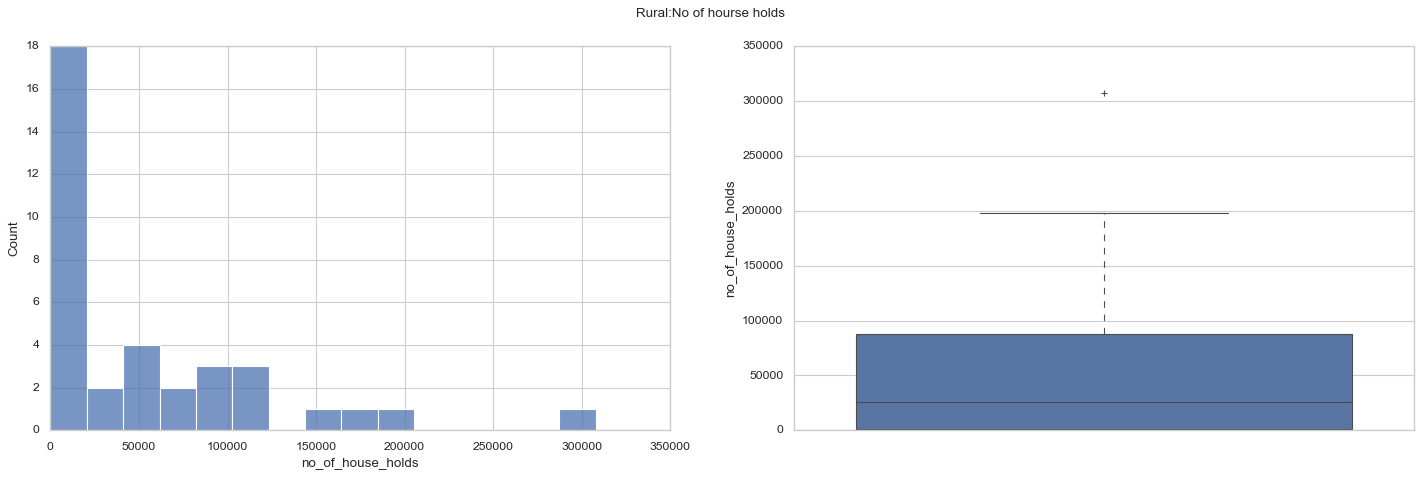

In [353]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, 6))
p1 = sns.histplot(df_nfhs_mpce_rural["no_of_house_holds"], binwidth=20000, ax=ax1)
p2 = sns.boxplot(df_nfhs_mpce_rural["no_of_house_holds"], ax=ax2)
plt.suptitle("Rural:No of hourse holds")
plt.show()

In [354]:
pd.DataFrame(df_nfhs_mpce_rural["no_of_house_holds"].describe()).T.apply(
    lambda x: round(x, 2)
)

,count,mean,std,min,25%,50%,75%,max
no_of_house_holds,36.0,53644.44,69193.94,26.0,1484.0,25765.0,87894.5,307870.0


**Inferences:**

These points are drawn based out of sample collected across 36 states in india.

- The average number of households is 53,644, but there is significant variation across states as indicated by the standard deviation.
- Half (50%) of the households have roughly 25,000.
- Three-quarters (75%) of the households have 87,000 or fewer.
- A small number of states have households exceeding 100,000.

### 2.2 How are the average MPCE data distributed collected in Rural Area?.

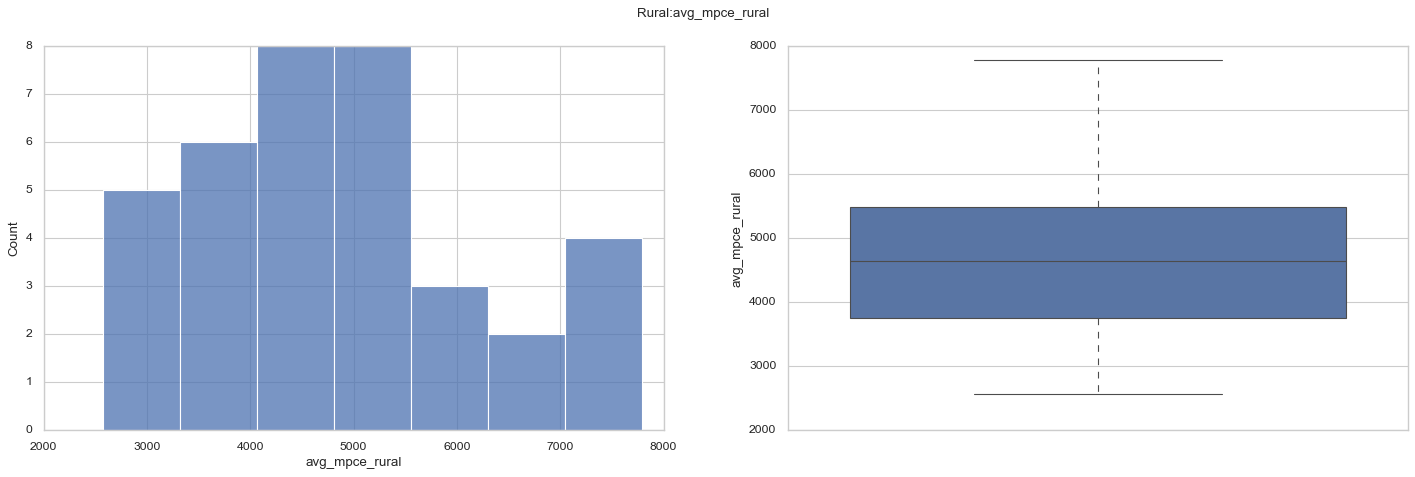

In [355]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, 6))
p1 = sns.histplot(df_nfhs_mpce_rural["avg_mpce_rural"], ax=ax1)
p2 = sns.boxplot(df_nfhs_mpce_rural["avg_mpce_rural"], ax=ax2)
plt.suptitle("Rural:avg_mpce_rural")
plt.show()

In [356]:
pd.DataFrame(df_nfhs_mpce_rural["avg_mpce_rural"].describe()).T.apply(
    lambda x: round(x, 2)
)

,count,mean,std,min,25%,50%,75%,max
avg_mpce_rural,36.0,4833.22,1391.89,2575.0,3751.5,4649.5,5486.0,7787.0


**Inferences:**

These points are drawn based out of sample collected across 36 states in india.

- The average Monthly Per Capita Expenditure (MPCE) in India is 4,833. However, there is significant variation in spending across households, as indicated by the standard deviation.
  
- Half Spend Less, Half Spend More: The median MPCE is 4,649, which is slightly lower than the average. This means that half of the households spend more than ₹4,649 per month on consumption, and the other half spend less.
  
- The MPCE follows a near-normal distribution, indicating a bell-shaped curve where most households' spending falls around the average.


### 2.3 Grouping the no of house hold data as in Rural Area and See how are their avg MPCE per each group?

In [357]:
df_nfhs_mpce_rural.loc[
    (df_nfhs_mpce_rural["no_of_house_holds"] < 1500), "house_hold_group"
] = "A:1-1499"

df_nfhs_mpce_rural.loc[
    (df_nfhs_mpce_rural["no_of_house_holds"] >= 1500)
    & (df_nfhs_mpce_rural["no_of_house_holds"] < 26000),
    "house_hold_group",
] = "B:1500-25999"

df_nfhs_mpce_rural.loc[
    (df_nfhs_mpce_rural["no_of_house_holds"] >= 26000)
    & (df_nfhs_mpce_rural["no_of_house_holds"] < 87999),
    "house_hold_group",
] = "C:26000-87999"

df_nfhs_mpce_rural.loc[
    (df_nfhs_mpce_rural["no_of_house_holds"] >= 88000), "house_hold_group"
] = "D:>=88000"

The previous analysis highlighted inconsistencies in the number of households surveyed across different states.  Since states with larger populations likely have more households, a consistent sample size per state might not have been achievable.

Grouping States by Household Count:

To address this, I have categorized the states into four groups based on the number of households in each state. The specific thresholds used for this grouping are as follows:

- A:1-1499
- B:1500-25999
- C:26000-87999
- D:>=88000

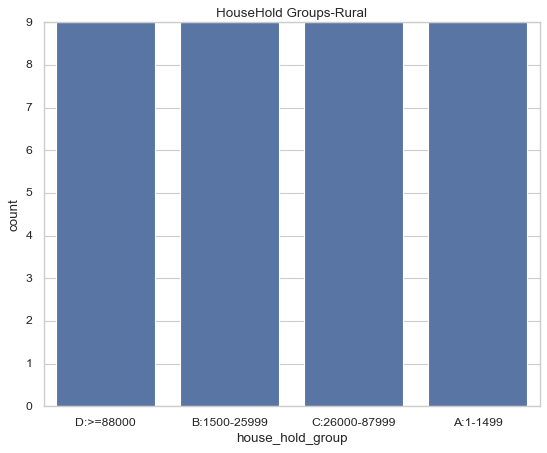

In [358]:
sns.countplot(df_nfhs_mpce_rural, x="house_hold_group")
plt.title("HouseHold Groups-Rural")
plt.show()

- Interestingly Each group has the same number of data points (9) for balanced representation.

In [359]:
df_nfhs_mpce_rural.groupby("house_hold_group").agg(
    {"avg_mpce_rural": [min, max, np.mean, np.median]}
).reset_index().apply(lambda x: round(x, 2))

house_hold_group avg_mpce_rural                       
                              min   max     mean  median
0         A:1-1499           4062  7787  6146.78  6595.0
1     B:1500-25999           3530  7388  4999.67  4721.0
2    C:26000-87999           2575  5960  4103.00  3820.0
3        D:>=88000           3158  5457  4083.44  4076.0

**Inferences**

- Interestingly, Group A (states with the fewest households, ranging from 1 to 1,499) has the highest average MPCE at 6,146.
- In contrast, Groups C and D exhibit a similar average MPCE of around 4,100.
- Group B (states with 1,500 to 25,999 households) falls in between, with an average MPCE of 5,000.

### 2.4 How are the house holds data distributed in Urban Area?.

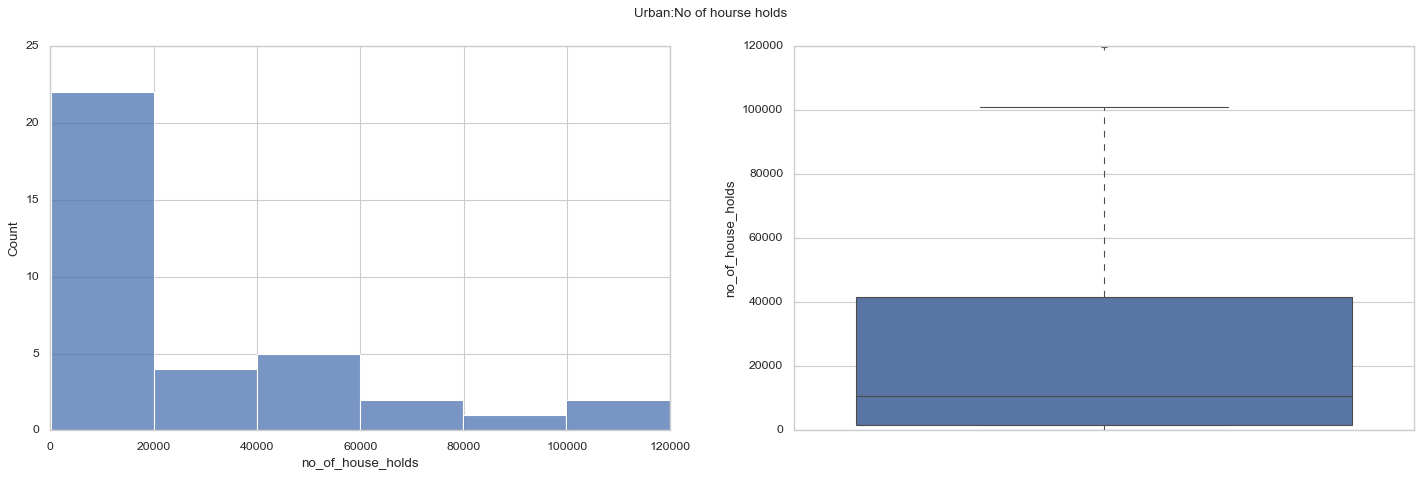

In [360]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, 6))
p1 = sns.histplot(df_nfhs_mpce_urban["no_of_house_holds"], binwidth=20000, ax=ax1)
p2 = sns.boxplot(df_nfhs_mpce_urban["no_of_house_holds"], ax=ax2)
plt.suptitle("Urban:No of hourse holds")
plt.show()

In [361]:
pd.DataFrame(df_nfhs_mpce_urban["no_of_house_holds"].describe()).T.apply(
    lambda x: round(x, 2)
)

,count,mean,std,min,25%,50%,75%,max
no_of_house_holds,36.0,24861.89,31406.13,79.0,1672.5,10788.5,41642.25,119824.0


**Inferences**

These points are drawn based out of sample collected across 36 states in india.

- The average number of households is 24,861 but there is significant variation across states as indicated by the standard deviation.
- Half (50%) of the households have roughly 10788.
- Three-quarters (75%) of the households have 42,000 members or fewer.
- A small number of states have households exceeding 100,000 members.

### 2.5 How are the average MPCE data distributed collected in Urban Area?.

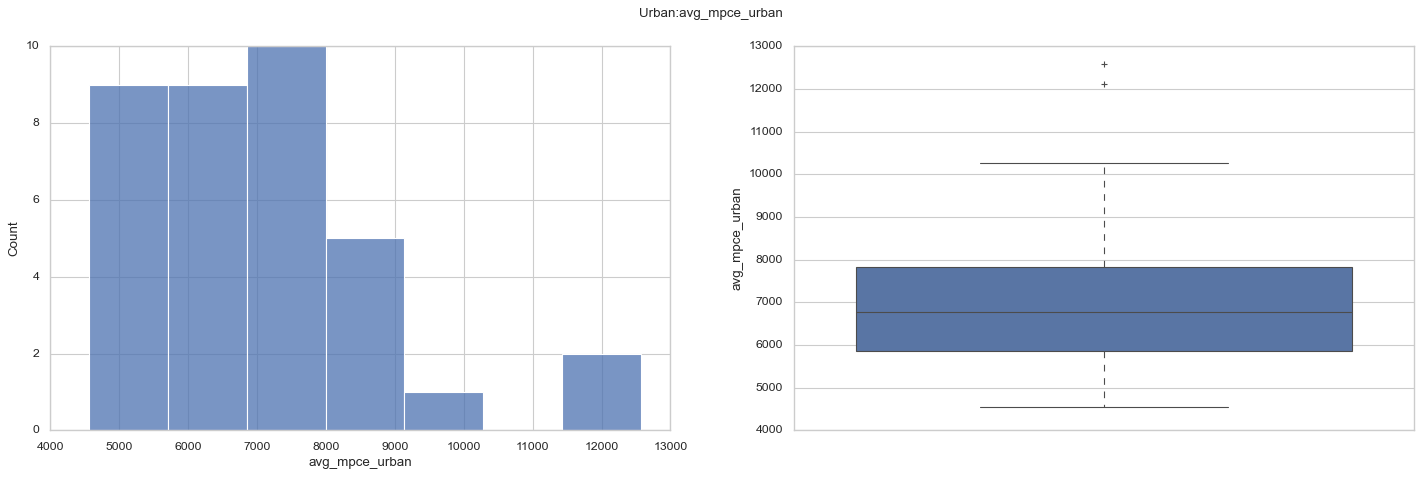

In [362]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, 6))
p1 = sns.histplot(df_nfhs_mpce_urban["avg_mpce_urban"], ax=ax1)
p2 = sns.boxplot(df_nfhs_mpce_urban["avg_mpce_urban"], ax=ax2)
plt.suptitle("Urban:avg_mpce_urban")
plt.show()

In [363]:
pd.DataFrame(df_nfhs_mpce_urban["avg_mpce_urban"].describe()).T.apply(
    lambda x: round(x, 2)
)

,count,mean,std,min,25%,50%,75%,max
avg_mpce_urban,36.0,7062.14,1853.39,4557.0,5855.25,6780.0,7822.75,12577.0


**Inferences:**

These points are drawn based out of sample collected across 36 states in india.

- The average Monthly Per Capita Expenditure (MPCE) in Urban is 7062. However, there is significant variation in spending across households, as indicated by the standard deviation.
  
- Half Spend Less, Half Spend More: The median MPCE is 6780, which is slightly lower than the average. This means that half of the households spend more than 6,780 per month on consumption, and the other half spend less.
  
- Thre are few assignable causes found in MPCE of Urban, The MPCE seems to not following near-normal distribution and the data exhibits a right skewed distribution.

### 2.6 Grouping the no of house hold data as in Urban Area and See how are their avg MPCE per each group?

In [364]:
df_nfhs_mpce_urban.loc[
    (df_nfhs_mpce_urban["no_of_house_holds"] < 1500), "house_hold_group"
] = "A:1-1499"

df_nfhs_mpce_urban.loc[
    (df_nfhs_mpce_urban["no_of_house_holds"] >= 1500)
    & (df_nfhs_mpce_urban["no_of_house_holds"] < 26000),
    "house_hold_group",
] = "B:1500-25999"

df_nfhs_mpce_urban.loc[
    (df_nfhs_mpce_urban["no_of_house_holds"] >= 26000)
    & (df_nfhs_mpce_urban["no_of_house_holds"] < 87999),
    "house_hold_group",
] = "C:26000-87999"

df_nfhs_mpce_urban.loc[
    (df_nfhs_mpce_urban["no_of_house_holds"] >= 88000), "house_hold_group"
] = "D:>=88000"

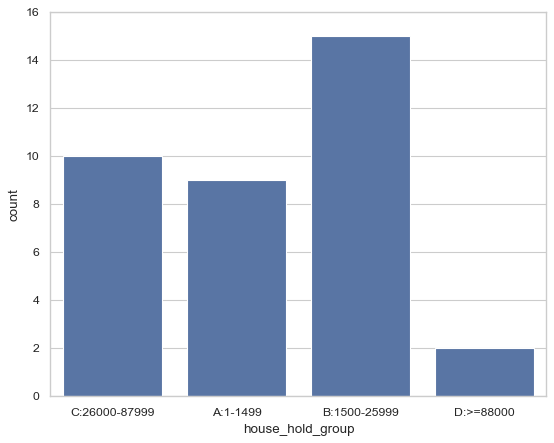

In [365]:
sns.countplot(df_nfhs_mpce_urban, x="house_hold_group")
plt.show()

- In contrast to the rural household groups with equal data points, the urban groups exhibit variation. For instance, Group A (1-1499 households) has 9 data points, while Group B has a higher number of data points at 15. This implies there are more urban states with a household count between 1,500 and 25,999 compared to other urban household categories.

In [366]:
df_nfhs_mpce_urban.groupby("house_hold_group").agg(
    {"avg_mpce_urban": [min, max, np.mean, np.median]}
).reset_index().apply(lambda x: round(x, 2))

house_hold_group avg_mpce_urban                        
                              min    max     mean  median
0         A:1-1499           5511  12125  7817.67  7159.0
1     B:1500-25999           4557  12577  6870.07  6577.0
2    C:26000-87999           5011   8251  6640.20  6753.5
3        D:>=88000           6683   7742  7212.50  7212.5

### 2.7 How is the data:the percentage contribution of MPCE is distributed in Rural ?

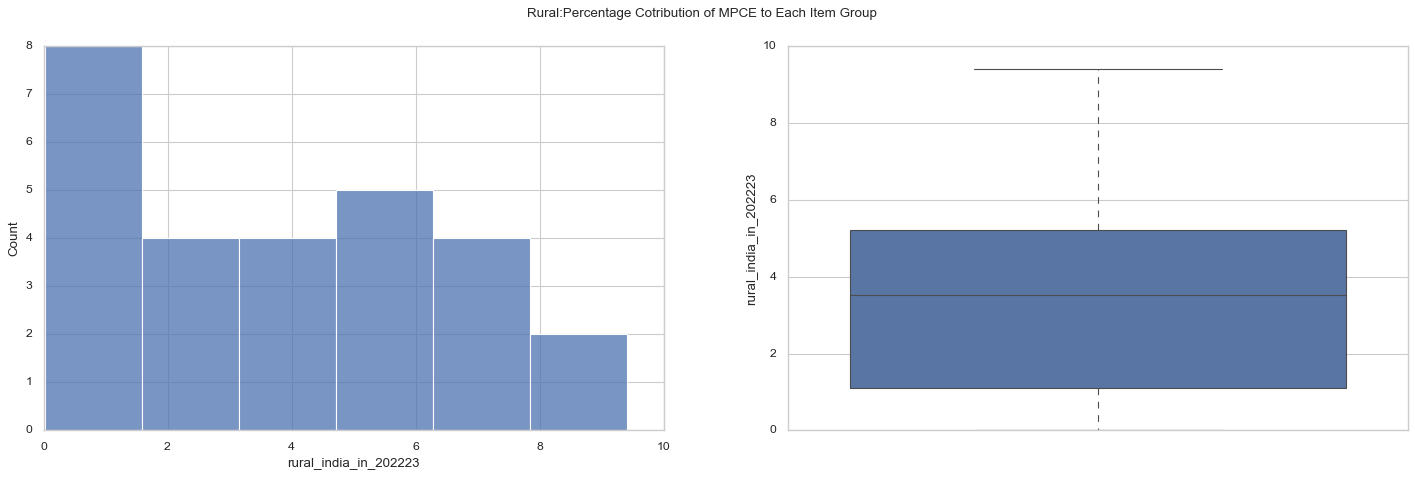

In [367]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, 6))
p1 = sns.histplot(df_nfhs_mpce_itemwise["rural_india_in_202223"], ax=ax1)
p2 = sns.boxplot(df_nfhs_mpce_itemwise["rural_india_in_202223"], ax=ax2)
plt.suptitle("Rural:Percentage Cotribution of MPCE to Each Item Group ")
plt.show()

In [368]:
pd.DataFrame(df_nfhs_mpce_itemwise["rural_india_in_202223"].describe()).T.apply(
    lambda x: round(x, 2)
)

,count,mean,std,min,25%,50%,75%,max
rural_india_in_202223,27.0,3.7,2.69,0.02,1.1,3.52,5.22,9.41


**Inferences:**

- In Rural areas, the average MPCE  across different item groups is roughly similar, regardless of whether we consider the mean or median values. This suggests a symmetrical distribution of spending patterns. On average, individuals in urban areas spend approximately 3.7 per item group.

### 2.8 How is the data:the percentage contribution of MPCE is distributed in Urban ?

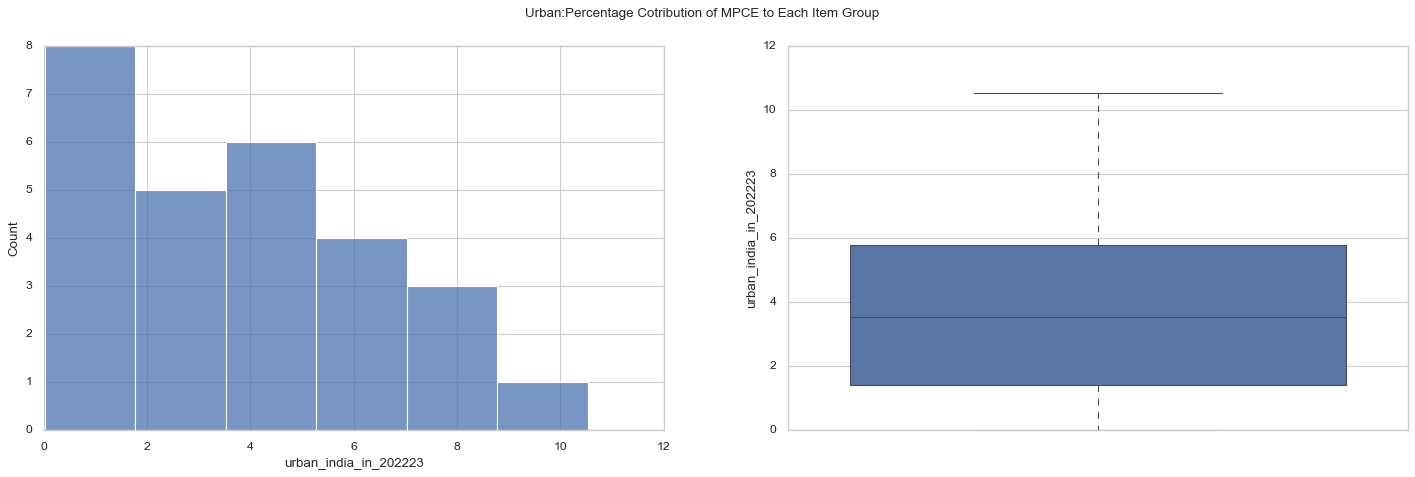

In [369]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, 6))
p1 = sns.histplot(df_nfhs_mpce_itemwise["urban_india_in_202223"], ax=ax1)
p2 = sns.boxplot(df_nfhs_mpce_itemwise["urban_india_in_202223"], ax=ax2)
plt.suptitle("Urban:Percentage Cotribution of MPCE to Each Item Group ")
plt.show()

In [370]:
pd.DataFrame(df_nfhs_mpce_itemwise["urban_india_in_202223"].describe()).T.apply(
    lambda x: round(x, 2)
)

,count,mean,std,min,25%,50%,75%,max
urban_india_in_202223,27.0,3.7,2.79,0.02,1.43,3.54,5.8,10.53


**Inferences**

- In urban areas too, the average MPCE  across different item groups is roughly similar, regardless of whether we consider the mean or median values. This suggests a symmetrical distribution of spending patterns. On average, individuals in urban areas spend approximately 3.7 per item group.

In [371]:
x1 = df_nfhs_mpce_itemwise[["item_group", "urban_india_in_202223"]].sort_values(
    "urban_india_in_202223", ascending=False
)
x2 = df_nfhs_mpce_itemwise[["item_group", "rural_india_in_202223"]].sort_values(
    "rural_india_in_202223", ascending=False
)

### 2.9 How is the the percentage contribution of MPCE per Eachh Item Group in Rural. ?

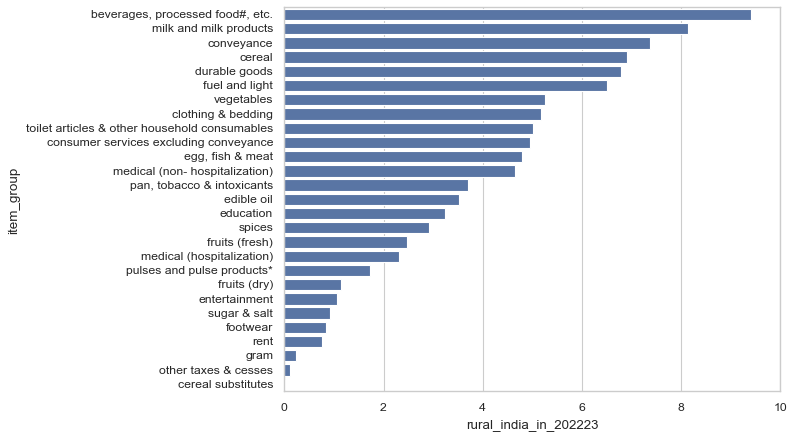

In [372]:
sns.barplot(x2, y="item_group", x="rural_india_in_202223")
plt.show()

**Inferences:**

- Higher Spending: The data suggests that Indians, particularly in urban areas allocate a significant portion of their monthly expenditure (MPCE) towards Food and Beverages, particularly milk and milk products. Additionally, conveyance appears to be another major spending category.

- Lower Spending: Rent, footwear, taxes & cesses, entertainment, and dry fruits seem to represent a smaller share of MPCE.
  
- Healthcare Concerns: The data also indicates potentially concerning levels of spending on hospitalizations.

### 2.10 How is the the percentage contribution of MPCE per Eachh Item Group in Urban. ?

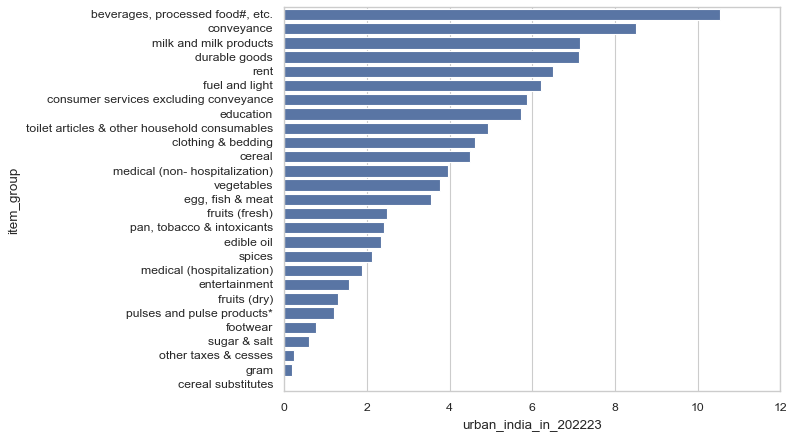

In [373]:
sns.barplot(x1, y="item_group", x="urban_india_in_202223")
plt.show()

**Inferences**

- While urban and rural populations allocate MPCE to the same item groups, the spending levels for these groups vary slightly, with urban residents spending somewhat more.

### 2.11 How does the Pareto Principle apply to MPCE in Rural areas? What percentage of Item Groups contribute to 80% of total spending?.

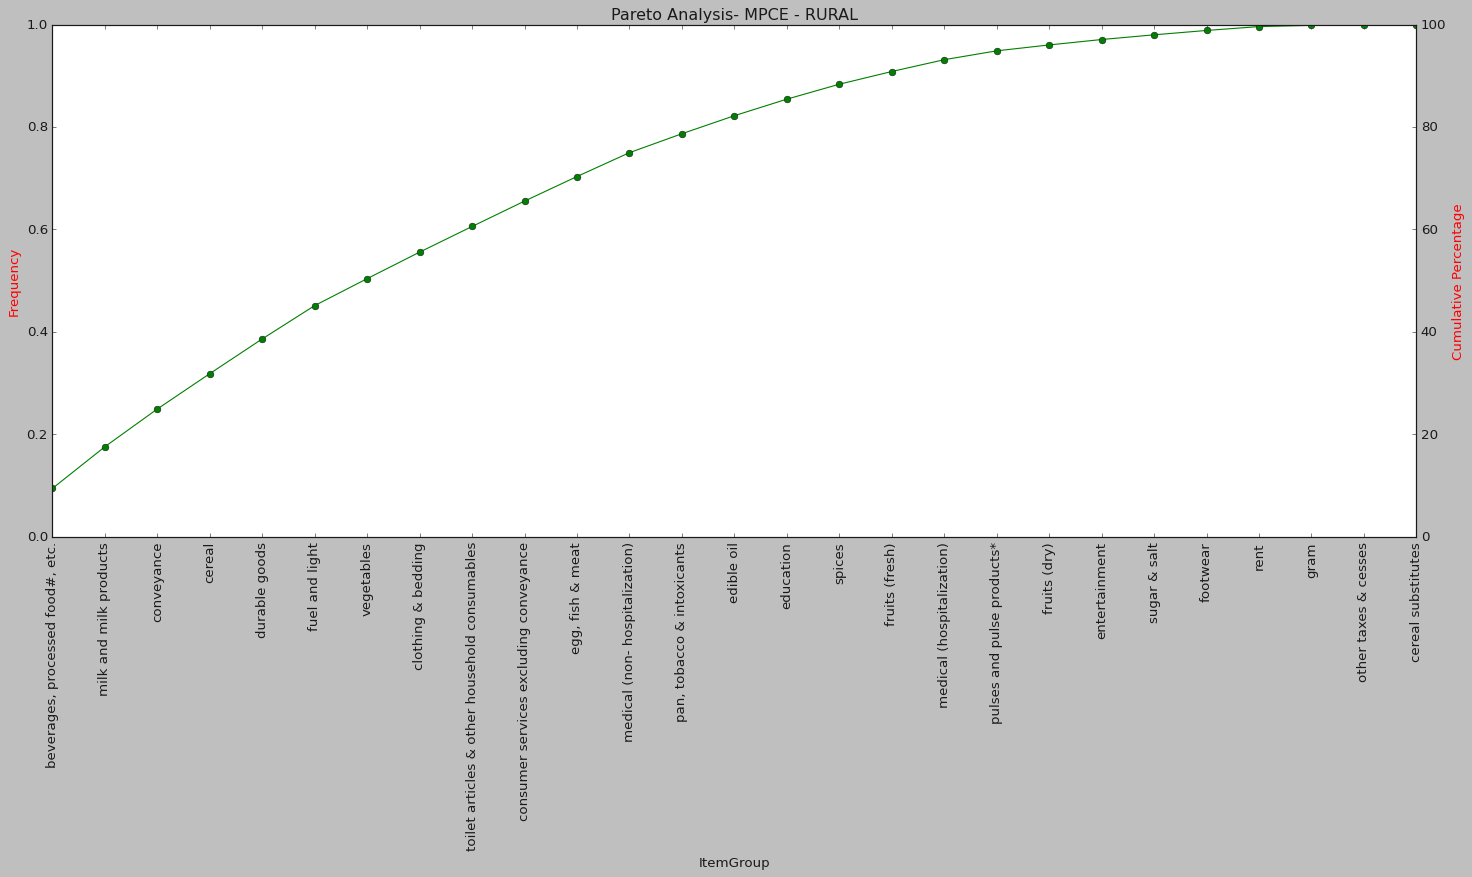

In [374]:
plt.style.use("classic")
# Pareto Diagram
sorted_data = df_nfhs_mpce_itemwise.sort_values(
    by=["rural_india_in_202223"], ascending=False
)
sorted_data["cumulative_freq"] = sorted_data["rural_india_in_202223"].cumsum()
sorted_data["cumulative_pct"] = (
    sorted_data["cumulative_freq"] / sorted_data["rural_india_in_202223"].sum() * 100
)

# Visualizations
fig, ax1 = plt.subplots(figsize=(22, 8))
ax2 = ax1.twinx()
ax2.plot(
    sorted_data["item_group"],
    sorted_data["cumulative_pct"],
    color="green",
    marker="o",
    linestyle="solid",
)
ax1.set_xlabel("ItemGroup")
ax1.set_ylabel("Frequency", color="red")
ax2.set_ylabel("Cumulative Percentage", color="red")
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)
plt.title("Pareto Analysis- MPCE - RURAL")
plt.show()
sns.set_theme("notebook", style="whitegrid")

**Inferences**

- In rural areas In 80%, around 50% of the average monthly expenditure is allocated towards essential goods like beverages, milk and milk products, conveyance, cereals, durable goods, fuel and light, vegetables, and clothing and bedding.

 - The remaining 30% of the monthly expenditure covers a broader range of categories, including toilet articles & other household consumables, consumer services (such as repairs or hairdressing), egg, fish & meat, tobacco products, and medical expenses (both hospitalization and non-hospitalization).
  

### 2.12 How does the Pareto Principle apply to MPCE in Urban areas? What percentage of Item Groups contribute to 80% of total spending?.

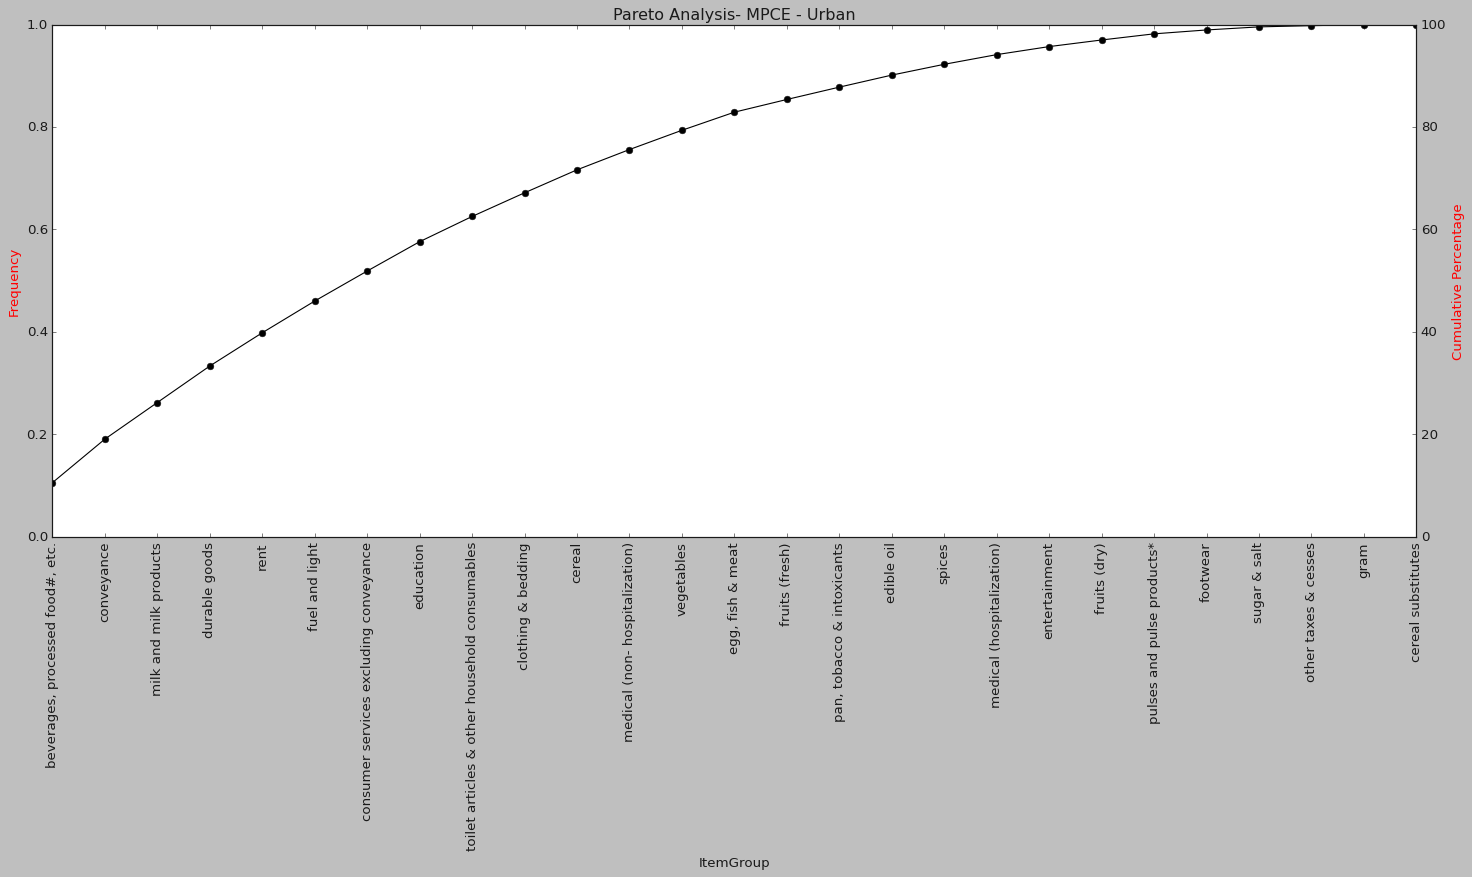

In [375]:
plt.style.use("classic")
# Pareto Diagram
sorted_data = df_nfhs_mpce_itemwise.sort_values(
    by=["urban_india_in_202223"], ascending=False
)
sorted_data["cumulative_freq"] = sorted_data["urban_india_in_202223"].cumsum()
sorted_data["cumulative_pct"] = (
    sorted_data["cumulative_freq"] / sorted_data["urban_india_in_202223"].sum() * 100
)

# Visualizations
fig, ax1 = plt.subplots(figsize=(22, 8))
ax2 = ax1.twinx()
ax2.plot(
    sorted_data["item_group"],
    sorted_data["cumulative_pct"],
    color="black",
    marker="o",
    linestyle="-",
)
ax1.set_xlabel("ItemGroup")
ax1.set_ylabel("Frequency", color="red")
ax2.set_ylabel("Cumulative Percentage", color="red")
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)
plt.title("Pareto Analysis- MPCE - Urban")
plt.show()
sns.set_theme("notebook", style="whitegrid")

**Inferences**

- In Urban areas In 80%, around 50% of the average monthly expenditure is allocated towards essential goods like beverages, milk and milk products, conveyance, durable goods, fuel and light, and consumer services.

 - The remaining 30% of the monthly expenditure covers a broader range of categories, education, toilet articles, clothing & bedding, cereal, vegetables and medical.

**In a conclusion**

- Households in both rural and urban areas dedicate roughly half of their monthly spending to essential goods like food, transportation, housing, utilities, and some basic services. The remaining portion is allocated to a wider range of categories, with some variation between the two areas. Rural areas spend more on necessities like clothing and fuel, while urban areas prioritize education and potentially more diverse services.

## 3.Unsupervised Analysis.


### Introduction to Unsupervised Learning Algorithms.

_Unsupervised learning is about finding insights & patterns hidden in the data, Unlike regression or classification, we don’t care about splitting our data into train / test sets and making predictions, we just care about understanding the relationships in our data._

**1.K-Means:**

K-Means Clustering is a popular algorithm which assigns each observation in a data set to a specific cluster, where “K” represents the number of clusters

Here’s how it works:

1. Select “K” arbitrary locations in a scatter plot as cluster centers (or centroids), and assign each observation to a cluster based on the closest centroid.
3. Recalculate and relocate each centroid to the mean of the observations assigned to it, then reassign each observation to its new closest centroid
4. Repeat the process until observations no longer change clusters.


**2.Hierarchical Clustering:**

Hierarchical Clustering is a clustering technique that creates clusters by grouping similar data points together

**3.DBSCAN:**

DBSCAN (Density-Based Spatial Clustering of Applications with Noise) is a clustering technique that identifies clusters based on the density of data points

Here’s how it works:

1. Select a radius (eps) and a minimum number of points (min_samples)
2. Within a scatter plot, label each point as one of the following:
   - Core point – has the minimum number of points within its radius (in a dense region)
   - Border point – does not have the minimum number of points within its radius, but has at least one core point within its radius (on the outskirts of clusters)
   - Noise point (outlier) – does not have a core point within its radius (isolated points)


### Rural - No of house holds and Average MPCE

- I have choses K as 2 to do carry out K-means  clustering on the Rural data of no of house holds and average MPCE as below.

In [376]:
df_X1 = df_nfhs_mpce_rural.drop(["state", "house_hold_group"], axis=1)

In [377]:
_model_spec_kmeans = KMeans(n_clusters=2, n_init="auto", random_state=2024)

In [378]:
_model_spec_kmeans.fit(df_X1)

KMeans(n_clusters=2, random_state=2024)

In [379]:
# combine the data and cluster labels
cluster_labels = pd.Series(_model_spec_kmeans.labels_, name="cluster")
# create a clean dataframe
df_clean = pd.concat([df_X1, cluster_labels], axis=1)

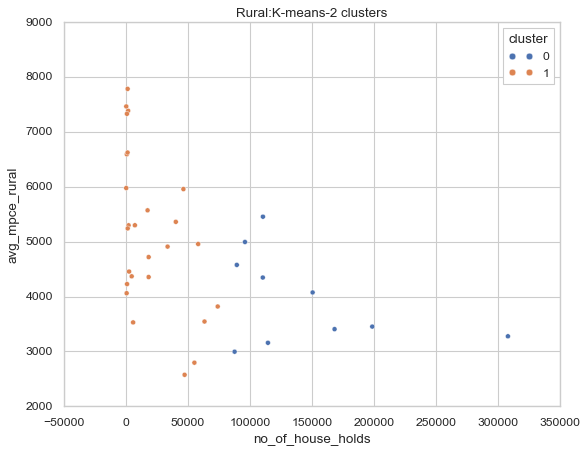

In [380]:
sns.scatterplot(df_clean, x="no_of_house_holds", y="avg_mpce_rural", hue="cluster")
plt.title("Rural:K-means-2 clusters")
plt.show()

**Inferences:**

- From the above scatterplot it is seen that the house holds between 1-50K and their AVG MPCE falls between 1500 and 8000 are clustered into one.
- The remaining larger no of housing i.e more than 80K are fit into 2nd cluster.

In [381]:
# view the cluster centers in a heatmap
cluster_centers2 = pd.DataFrame(
    _model_spec_kmeans.cluster_centers_, columns=df_X1.columns
)
cluster_centers2.apply(lambda x: round(x, 2))

,no_of_house_holds,avg_mpce_rural
0,143205.00,3974.70
1,19198.08,5163.42


**Inferences:**

- Cluster 2 has a higher average MPCE (5163) compared to Cluster 1 (3974). This suggests a difference of 1189 in average spending.
 
- While the average MPCE in Cluster 1 is 3974, Cluster 2 has a slightly higher average of 5163. The difference between the two clusters is around 1189.
 More neutral phrasing:

- The average MPCE in Cluster 1 is 3974, while in Cluster 2 it is 5163.

**To gain insights from the data, I will identify the optimal number of clusters (K) by minimizing the within-cluster sum of squares (WCSS). WCSS measures how spread out the data points are within each cluster, which can be done through Inertia Metric.**

In [382]:
# create an empty list to hold many inertia values
inertia_values = []
# create 2 - 15 clusters, and add the intertia scores to the list
for k in range(2, 16):
    kmeans = KMeans(n_clusters=k, n_init="auto", random_state=42)
    kmeans.fit(df_X1)
    inertia_values.append(kmeans.inertia_)

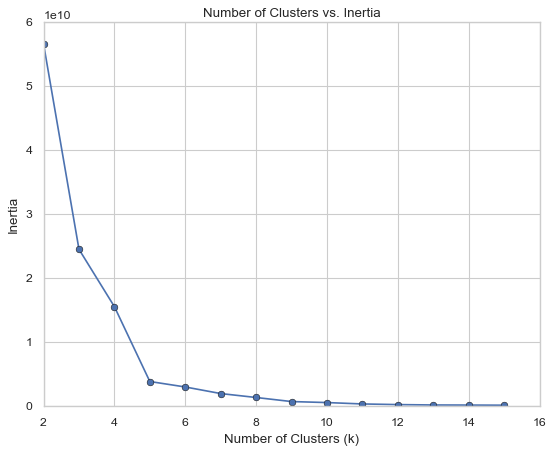

In [383]:
# turn the list into a series for plotting
inertia_series = pd.Series(inertia_values, index=range(2, 16))
# plot the data
inertia_series.plot(marker="o")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.title("Number of Clusters vs. Inertia");

- Based on the inertia plot, using 5 clusters seems effective for revealing patterns in the rural data.

In [384]:
# now for 5 clusters
kmeans4 = KMeans(n_clusters=5, n_init="auto", random_state=2024)
kmeans4.fit(df_X1)

KMeans(n_clusters=5, random_state=2024)

In [385]:
# view the cluster centers in a dataframe
cluster_centers4 = pd.DataFrame(kmeans4.cluster_centers_, columns=df_X1.columns)
cluster_centers4 = cluster_centers4.apply(lambda x: round(x, 2))

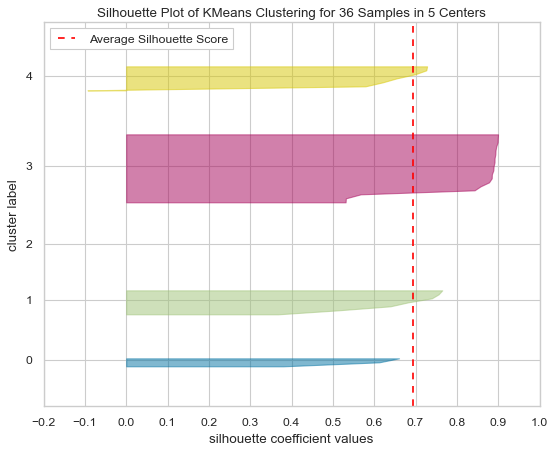

In [386]:
custom_sillaoute_score_plot(kmeans4, df_X1)

- The silhouette plot helps visualize how well data points are clustered in k-means. By analyzing the distribution of silhouette values, we can assess the quality of the clustering and potentially identify areas for improvement.

- The silhouette plot indicates a positive outcome for the 5-cluster solution. Four clusters have silhouette scores above 0.7, signifying that points within those clusters are well-positioned and have a significant separation from points in other clusters. This suggests good cluster separation and well-defined clusters.

In [387]:
# combine the data and cluster labels
cluster_labels = pd.Series(kmeans4.labels_, name="cluster")

# create a clean dataframe
df_clean_4 = pd.concat([df_X1, cluster_labels], axis=1)

df_nfhs_mpce_rural_tidy = pd.concat(
    [
        df_nfhs_mpce_rural,
        df_clean_4["cluster"],
        df_state_codes.iloc[:36,].loc[:, "state_short_code"],
    ],
    axis=1,
)

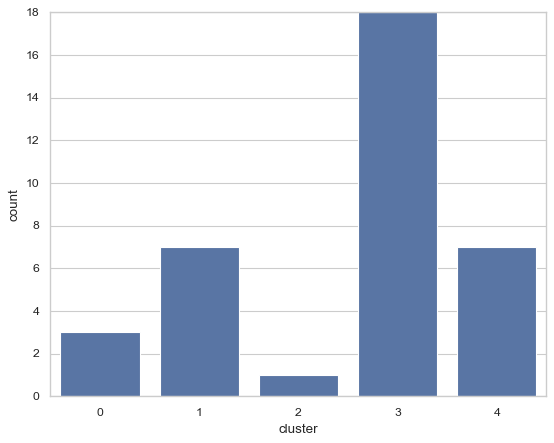

In [388]:
sns.countplot(df_nfhs_mpce_rural_tidy, x="cluster")
plt.show()

In [389]:
cluster_centers4

,no_of_house_holds,avg_mpce_rural
0,172293.67,3645.67
1,48997.86,4301.57
2,307870.00,3277.00
3,4574.94,5573.22
4,97302.14,4193.29


**Inferences:**

- The cluster number 3 has the highest average mpce i.e 5573 compare to the remaining 4 clusters.
- The cluster number 2 has lowest average mpce i.e 3277 within the 5 clusters.

**Let's explore the data patterns within each of the five clusters by examining the rural states belonging to those clusters.**

**Rural-Cluster#0:**

In [390]:
df_nfhs_mpce_rural_tidy.loc[df_nfhs_mpce_rural_tidy["cluster"] == 0, :]

,state,no_of_house_holds,avg_mpce_rural,house_hold_group,cluster,state_short_code
3,Bihar,198464,3454,D:>=88000,0,BH
14,Maharashtra,150360,4076,D:>=88000,0,MH
28,West Bengal,168057,3407,D:>=88000,0,WB


_Rural households from Bihar, Maharashtra, and West Bengal appear to be grouped together in one cluster. This cluster has a larger number of households and a lower average MPCE of 3645, suggesting a potential association with a lower standard of living._

**Rural-Cluster#1:**

In [391]:
df_nfhs_mpce_rural_tidy.loc[df_nfhs_mpce_rural_tidy["cluster"] == 1, :]

,state,no_of_house_holds,avg_mpce_rural,house_hold_group,cluster,state_short_code
2,Assam,63174,3546,C:26000-87999,1,AS
4,Chhattisgarh,47120,2575,C:26000-87999,1,CT
8,Haryana,33394,4912,C:26000-87999,1,HR
10,Jharkhand,55031,2796,C:26000-87999,1,JH
12,Kerala,46172,5960,C:26000-87999,1,KL
20,Punjab,40039,5363,C:26000-87999,1,PB
24,Telangana,58055,4959,C:26000-87999,1,TS


_Rural households from Assam, Chattisgarh, Haryana, Jharkhand,Kerala, punjab and Telangana appear to be grouped together in one cluster. This cluster has moderate average MPCE of 4301, suggesting a potential association with a better standard of living._

**Rural-Cluster#2:**

In [392]:
df_nfhs_mpce_rural_tidy.loc[df_nfhs_mpce_rural_tidy["cluster"] == 2, :]

,state,no_of_house_holds,avg_mpce_rural,house_hold_group,cluster,state_short_code
27,Uttar Pradesh,307870,3277,D:>=88000,2,UP


_Rural households from Uttar Pradesh only to be grouped together in one cluster. This cluster has the least average MPCE of 3277, suggesting a potential association with a poor standard of living._

**Rural-Cluster#3:**

In [393]:
df_nfhs_mpce_rural_tidy.loc[df_nfhs_mpce_rural_tidy["cluster"] == 3, :]

,state,no_of_house_holds,avg_mpce_rural,house_hold_group,cluster,state_short_code
1,Arunachal Pradesh,1953,5300,B:1500-25999,3,AR
5,Delhi,510,6595,A:1-1499,3,DL
6,Goa,1569,7388,B:1500-25999,3,GA
9,Himachal Pradesh,17260,5573,B:1500-25999,3,HP
15,Manipur,4440,4370,B:1500-25999,3,MN
16,Meghalaya,5610,3530,B:1500-25999,3,ME
17,Mizoram,1229,5243,A:1-1499,3,MZ
18,Nagaland,2341,4457,B:1500-25999,3,NL
22,Sikkim,1189,7787,A:1-1499,3,SK
25,Tripura,7032,5301,B:1500-25999,3,TR


_Rural households from the smaller states to be grouped together in one cluster. This cluster has the the best average MPCE of 5573, suggesting a potential association with a standard of living in small states._

**Rural-Cluster#4:**

In [394]:
df_nfhs_mpce_rural_tidy.loc[df_nfhs_mpce_rural_tidy["cluster"] == 4, :]

,state,no_of_house_holds,avg_mpce_rural,house_hold_group,cluster,state_short_code
0,Andhra Pradesh,95813,4996,D:>=88000,4,AP
7,Gujarat,73816,3820,C:26000-87999,4,GJ
11,Karnataka,89231,4578,D:>=88000,4,KA
13,Madhya Pradesh,114334,3158,D:>=88000,4,MP
19,Odisha,87449,2996,C:26000-87999,4,OR
21,Rajasthan,110176,4348,D:>=88000,4,RJ
23,Tamil Nadu,110296,5457,D:>=88000,4,TN


_Rural households from Andhrpradhesh, gujaraj, karnataka, MP, Odisha, Rajasthan and tamilnadu appear to be grouped together in one cluster. This cluster has second better average MPCE of 4193, suggesting a potential association with a better standard of living._

### Urban - No of house holds and Average MPCE.

**I will carry out the same clustering analysis on Urban data as follows.**

In [395]:
df_X2 = df_nfhs_mpce_urban.drop(["state", "house_hold_group"], axis=1)

In [396]:
# create an empty list to hold many inertia values
inertia_values = []
# create 2 - 15 clusters, and add the intertia scores to the list
for k in range(2, 16):
    kmeans = KMeans(n_clusters=k, n_init="auto", random_state=42)
    kmeans.fit(df_X2)
    inertia_values.append(kmeans.inertia_)

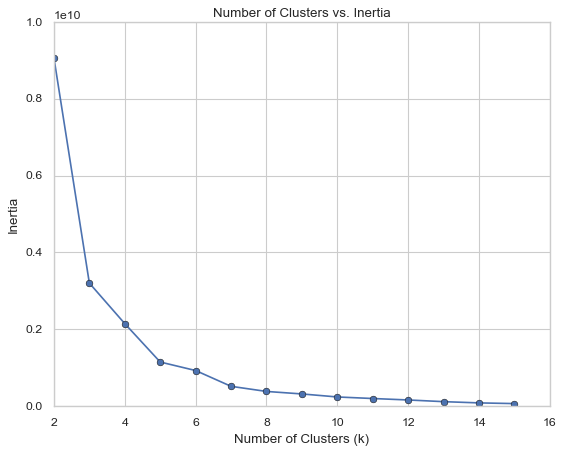

In [397]:
# turn the list into a series for plotting
inertia_series = pd.Series(inertia_values, index=range(2, 16))

# plot the data
inertia_series.plot(marker="o")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.title("Number of Clusters vs. Inertia");

- Based on the inertia plot, using 5 clusters seems effective for revealing patterns in the urban data as well.

In [398]:
# now for 5 clusters
kmeans4_urban = KMeans(n_clusters=5, n_init="auto", random_state=42)
kmeans4_urban.fit(df_X2)

KMeans(n_clusters=5, random_state=42)

In [399]:
# view the cluster centers in a dataframe
cluster_centers_urban = pd.DataFrame(
    kmeans4_urban.cluster_centers_, columns=df_X2.columns
)
cluster_centers_urban = cluster_centers_urban.apply(lambda x: round(x, 2))

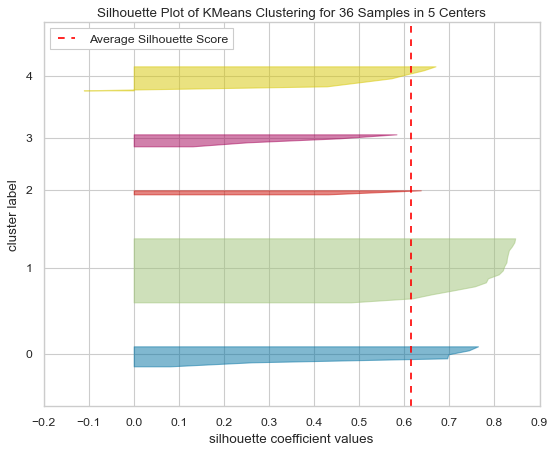

In [400]:
custom_sillaoute_score_plot(kmeans4_urban, df_X2)

- The silhouette plot indicates a positive outcome for the 5-cluster solution. Four clusters have silhouette scores above 0.6, signifying that points within those clusters are well-positioned and have a significant separation from points in other clusters. This suggests good cluster separation and well-defined clusters of Urban data as well.

In [401]:
# combine the data and cluster labels
cluster_labels = pd.Series(kmeans4_urban.labels_, name="cluster")

# create a clean dataframe
df_clean_urban = pd.concat([df_X2, cluster_labels], axis=1)

df_nfhs_mpce_urban_tidy = pd.concat(
    [
        df_nfhs_mpce_urban,
        df_clean_urban["cluster"],
        df_state_codes.iloc[:36,].loc[:, "state_short_code"],
    ],
    axis=1,
)

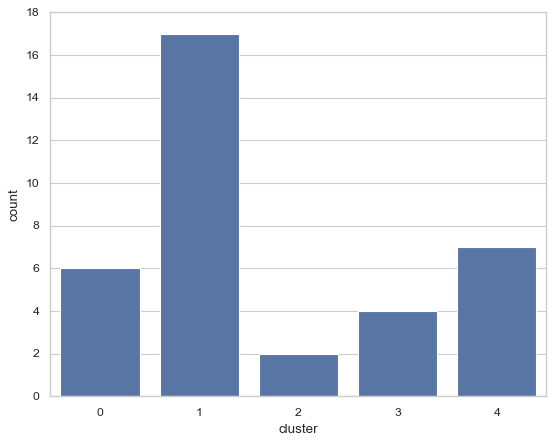

In [402]:
sns.countplot(df_nfhs_mpce_urban_tidy, x="cluster")
plt.show()

In [403]:
cluster_centers_urban

,no_of_house_holds,avg_mpce_urban
0,41933.83,6910.17
1,1868.18,7831.18
2,110502.00,7212.50
3,68454.25,6235.25
4,16692.14,5754.29


**Inferences:**

- The cluster number 1 has the highest average mpce i.e 7831 compare to the remaining 4 clusters.
- The cluster number 4 has lowest average mpce i.e 5744 within the 5 clusters.

**Let's explore the data patterns within each of the five clusters by examining the urban states belonging to those clusters.**

**Cluster#0:**

In [404]:
df_nfhs_mpce_urban_tidy.loc[df_nfhs_mpce_urban_tidy["cluster"] == 0, :]

,state,no_of_house_holds,avg_mpce_urban,house_hold_group,cluster,state_short_code
0,Andhra Pradesh,45443,6877,C:26000-87999,0,AP
5,Delhi,30965,8250,C:26000-87999,0,DL
12,Kerala,42846,7102,C:26000-87999,0,KL
13,Madhya Pradesh,41241,5011,C:26000-87999,0,MP
21,Rajasthan,39106,5970,C:26000-87999,0,RJ
24,Telangana,52002,8251,C:26000-87999,0,TS


_Urban households from AP, Delhi, Kerala,MP,Rajasthan and Telangana appear to be grouped together in one cluster. This cluster has a moderate average MPCE of 6910, suggesting a potential association with a better standard of living._

**Cluster#1:**

In [405]:
df_nfhs_mpce_urban_tidy.loc[df_nfhs_mpce_urban_tidy["cluster"] == 1, :]

,state,no_of_house_holds,avg_mpce_urban,house_hold_group,cluster,state_short_code
1,Arunachal Pradesh,602,8649,A:1-1499,1,AR
6,Goa,2270,8761,B:1500-25999,1,GA
9,Himachal Pradesh,2601,8083,B:1500-25999,1,HP
15,Manipur,1767,4902,B:1500-25999,1,MN
16,Meghalaya,1112,6450,A:1-1499,1,ME
17,Mizoram,1033,7664,A:1-1499,1,MZ
18,Nagaland,979,7159,A:1-1499,1,NL
22,Sikkim,608,12125,A:1-1499,1,SK
25,Tripura,2083,7473,B:1500-25999,1,TR
26,Uttarakhand,5353,7034,B:1500-25999,1,UK


_Urban households from Small states appear to be grouped together in one cluster. This cluster has a moderate average MPCE of 7831, suggesting a potential association with the best standard of living._

**Cluster#2:**

In [406]:
df_nfhs_mpce_urban_tidy.loc[df_nfhs_mpce_urban_tidy["cluster"] == 2, :]

,state,no_of_house_holds,avg_mpce_urban,house_hold_group,cluster,state_short_code
14,Maharashtra,119824,6683,D:>=88000,2,MH
23,Tamil Nadu,101180,7742,D:>=88000,2,TN


_Urban households from Maharasthra and Tamilnadu to be grouped together in one cluster. This cluster has a moderate average MPCE of 7212, suggesting a potential association with a better standard of living._

**Cluster#3:**

In [407]:
df_nfhs_mpce_urban_tidy.loc[df_nfhs_mpce_urban_tidy["cluster"] == 3, :]

,state,no_of_house_holds,avg_mpce_urban,house_hold_group,cluster,state_short_code
7,Gujarat,58955,6630,C:26000-87999,3,GJ
11,Karnataka,61965,7781,C:26000-87999,3,KA
27,Uttar Pradesh,85072,5104,C:26000-87999,3,UP
28,West Bengal,67825,5426,C:26000-87999,3,WB


_Urban households from Gujarat,Karnataka,UP and WB to be grouped together in one cluster. This cluster has a moderate average MPCE of 6235, suggesting a potential association with a nominal standard of living._

**Cluster#4:**

In [408]:
df_nfhs_mpce_urban_tidy.loc[df_nfhs_mpce_urban_tidy["cluster"] == 4, :]

,state,no_of_house_holds,avg_mpce_urban,house_hold_group,cluster,state_short_code
2,Assam,9279,6210,B:1500-25999,4,AS
3,Bihar,18955,4819,B:1500-25999,4,BH
4,Chhattisgarh,12298,4557,B:1500-25999,4,CT
8,Haryana,22330,7948,B:1500-25999,4,HR
10,Jharkhand,14021,4946,B:1500-25999,4,JH
19,Odisha,15796,5223,B:1500-25999,4,OR
20,Punjab,24166,6577,B:1500-25999,4,PB


_Urban households from Assam,Bihar Chattisgarh,Haryana,Jharkhand,Odisha and Punjab be grouped together in one cluster. This cluster has a lease average MPCE of 5754, suggesting a potential association with a poor standard of living._

### Item Group: Percentage Cotribution of MPCE to Each Item.

**Glance at item group data**

In [409]:
df_nfhs_mpce_itemwise.head()

,item_group,rural_india_in_202223,urban_india_in_202223
0,cereal,6.90,4.49
1,cereal substitutes,0.02,0.02
2,gram,0.24,0.18
3,pulses and pulse products*,1.73,1.20
4,sugar & salt,0.92,0.60


**This item-group data, segmented by rural and urban locations, will be analyzed using various clustering techniques to identify potential patterns.**

### KMeans.

In [410]:
df_X3 = df_nfhs_mpce_itemwise.drop(["item_group"], axis=1)

In [411]:
# create an empty list to hold many inertia values
inertia_values = []
# create 2 - 15 clusters, and add the intertia scores to the list
for k in range(2, 16):
    kmeans = KMeans(n_clusters=k, n_init="auto", random_state=42)
    kmeans.fit(df_X3)
    inertia_values.append(kmeans.inertia_)

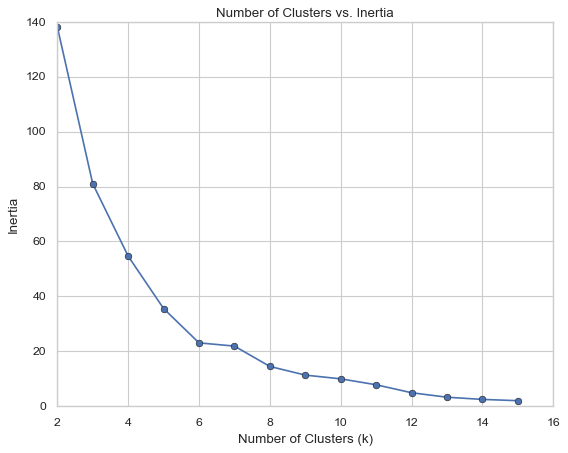

In [412]:
# turn the list into a series for plotting
inertia_series = pd.Series(inertia_values, index=range(2, 16))

# plot the data
inertia_series.plot(marker="o")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.title("Number of Clusters vs. Inertia");

- Based on the inertia plot, using 5 clusters seems effective for revealing patterns in the item-group data.

In [413]:
# now for 5 clusters
kmeans_ITEM = KMeans(n_clusters=5, n_init="auto", random_state=2024)
kmeans_ITEM.fit(df_X3)

KMeans(n_clusters=5, random_state=2024)

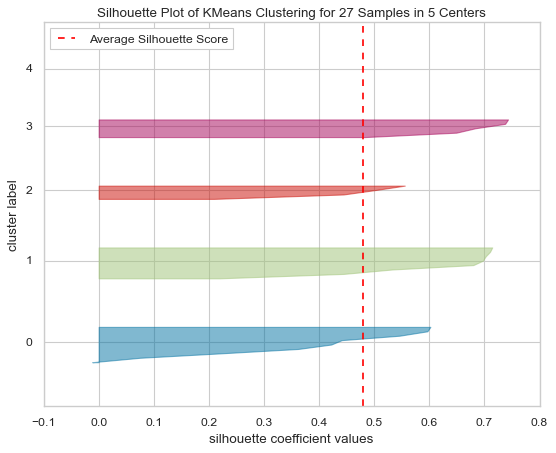

In [414]:
custom_sillaoute_score_plot(kmeans_ITEM, df_X3)

- The silhouette plot indicates a positive outcome for the 5-cluster solution. Four clusters have silhouette scores above 0.5, signifying that points within those clusters are well-positioned and have a significant separation from points in other clusters.

In [415]:
# view the cluster centers in a dataframe
cluster_centers_ITEM = pd.DataFrame(kmeans_ITEM.cluster_centers_, columns=df_X3.columns)
cluster_centers_ITEM = cluster_centers_ITEM.apply(lambda x: round(x, 2))

In [416]:
# combine the data and cluster labels
cluster_labels = pd.Series(kmeans_ITEM.labels_, name="cluster")

# create a clean dataframe
df_clean_item = pd.concat([df_X3, cluster_labels], axis=1)

df_nfhs_mpce_item_tidy = pd.concat(
    [
        df_nfhs_mpce_itemwise,
        df_clean_item["cluster"],
    ],
    axis=1,
)

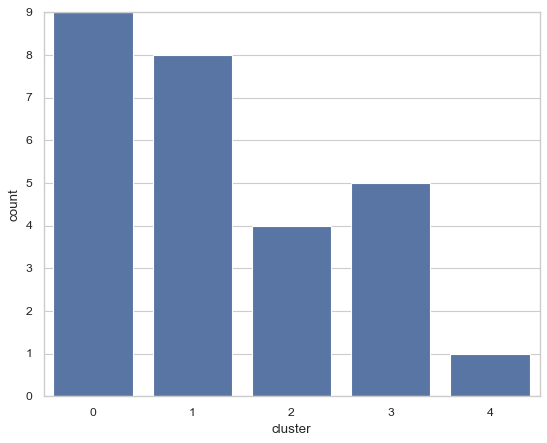

In [417]:
sns.countplot(df_nfhs_mpce_item_tidy, x="cluster")
plt.show()

In [418]:
cluster_centers_ITEM

,rural_india_in_202223,urban_india_in_202223
0,5.17,4.79
1,0.76,0.73
2,7.93,8.33
3,2.99,2.25
4,0.76,6.49


**Inferences:**

- The cluster number 2 has the highest average percentage of contributions from MPCE to the item-groups i.e 7.93 in rural and 8.33 in urban compare to the remaining 4 clusters.
- The cluster number 1 and 2 have least average percentage of contributions i.e 0.76 in rural ad 0.73 in urban within the 5 clusters.

**Cluster#0**

In [419]:
df_nfhs_mpce_item_tidy.loc[df_nfhs_mpce_item_tidy["cluster"] == 0, :]

,item_group,rural_india_in_202223,urban_india_in_202223,cluster
0,cereal,6.90,4.49,0
6,vegetables,5.26,3.76,0
9,"egg, fish & meat",4.80,3.54,0
14,fuel and light,6.51,6.20,0
15,toilet articles & other household consumables,5.01,4.93,0
16,education,3.23,5.73,0
18,medical (non- hospitalization),4.66,3.96,0
20,consumer services excluding conveyance,4.96,5.86,0
24,clothing & bedding,5.18,4.62,0


_Cluster 0 appears to group item categories (cereals, vegetables, egg, fish & meat, fuel & light, toilets, education, non-hospitalization medication, consumer services, and clothing & bedding) where the average MPCE contributions from rural and urban areas are similar._

**Cluster#1**

In [420]:
df_nfhs_mpce_item_tidy.loc[df_nfhs_mpce_item_tidy["cluster"] == 1, :]

,item_group,rural_india_in_202223,urban_india_in_202223,cluster
1,cereal substitutes,0.02,0.02,1
2,gram,0.24,0.18,1
3,pulses and pulse products*,1.73,1.20,1
4,sugar & salt,0.92,0.60,1
8,fruits (dry),1.15,1.29,1
21,entertainment,1.06,1.57,1
23,other taxes & cesses,0.12,0.24,1
25,footwear,0.85,0.76,1


_Cluster 1 appears to group item categories (cereals substistues, gram, pulse product, sugar &salt, fruits, enteraiment, other taxes and footwear) where the average MPCE contributions from rural and urban areas are similar._

**Cluster#2**

In [421]:
df_nfhs_mpce_item_tidy.loc[df_nfhs_mpce_item_tidy["cluster"] == 2, :]

,item_group,rural_india_in_202223,urban_india_in_202223,cluster
5,milk and milk products,8.14,7.15,2
12,"beverages, processed food#, etc.",9.41,10.53,2
19,conveyance,7.38,8.51,2
26,durable goods,6.79,7.13,2


_Cluster 2 appears to group item categories (milk product, beverages, processed foods, conveynace and durable goods) where the average MPCE contributions from urban areas is little higher than rural_

**Cluster#3**

In [422]:
df_nfhs_mpce_item_tidy.loc[df_nfhs_mpce_item_tidy["cluster"] == 3, :]

,item_group,rural_india_in_202223,urban_india_in_202223,cluster
7,fruits (fresh),2.48,2.48,3
10,edible oil,3.52,2.35,3
11,spices,2.92,2.11,3
13,"pan, tobacco & intoxicants",3.70,2.41,3
17,medical (hospitalization),2.31,1.89,3


_Cluster 3 appears to group item categories (fresh fruits, edibile oil, spices, tobaco and medical hospitalization) where the average MPCE contributions from rural and urban areas are similar._

**Cluster#4**

In [423]:
df_nfhs_mpce_item_tidy.loc[df_nfhs_mpce_item_tidy["cluster"] == 4, :]

,item_group,rural_india_in_202223,urban_india_in_202223,cluster
22,rent,0.76,6.49,4


_Interestingly, Cluster 4 consists solely of the "rent" category. The MPCE contribution for rent appears to be higher in urban areas compared to rural areas within this cluster._

**I will now use hierarchical and DBSCAN clustering to see if they reveal similar patterns.**

### Agglomarative.

In [424]:
_agg_cluster = AgglomerativeClustering(n_clusters=5, metric="euclidean", linkage="ward")

In [425]:
_agg_cluster.fit(df_X3)

AgglomerativeClustering(n_clusters=5)

In [426]:
df_agg = pd.DataFrame({"cluster": list(_agg_cluster.labels_)})

In [427]:
df_items_clusters = pd.concat([df_nfhs_mpce_itemwise, df_agg], axis=1)

**Cluster#0**

In [428]:
df_items_clusters.loc[df_items_clusters["cluster"] == 0, :]

,item_group,rural_india_in_202223,urban_india_in_202223,cluster
5,milk and milk products,8.14,7.15,0
12,"beverages, processed food#, etc.",9.41,10.53,0
14,fuel and light,6.51,6.20,0
19,conveyance,7.38,8.51,0
26,durable goods,6.79,7.13,0


**Cluster#1**

In [429]:
df_items_clusters.loc[df_items_clusters["cluster"] == 1, :]

,item_group,rural_india_in_202223,urban_india_in_202223,cluster
1,cereal substitutes,0.02,0.02,1
2,gram,0.24,0.18,1
3,pulses and pulse products*,1.73,1.20,1
4,sugar & salt,0.92,0.60,1
8,fruits (dry),1.15,1.29,1
21,entertainment,1.06,1.57,1
23,other taxes & cesses,0.12,0.24,1
25,footwear,0.85,0.76,1


**Cluster#2**

In [430]:
df_items_clusters.loc[df_items_clusters["cluster"] == 2, :]

,item_group,rural_india_in_202223,urban_india_in_202223,cluster
0,cereal,6.90,4.49,2
6,vegetables,5.26,3.76,2
9,"egg, fish & meat",4.80,3.54,2
15,toilet articles & other household consumables,5.01,4.93,2
16,education,3.23,5.73,2
18,medical (non- hospitalization),4.66,3.96,2
20,consumer services excluding conveyance,4.96,5.86,2
24,clothing & bedding,5.18,4.62,2


**Cluster#3**

In [431]:
df_items_clusters.loc[df_items_clusters["cluster"] == 3, :]

,item_group,rural_india_in_202223,urban_india_in_202223,cluster
7,fruits (fresh),2.48,2.48,3
10,edible oil,3.52,2.35,3
11,spices,2.92,2.11,3
13,"pan, tobacco & intoxicants",3.70,2.41,3
17,medical (hospitalization),2.31,1.89,3


**Cluster#4**

In [432]:
df_items_clusters.loc[df_items_clusters["cluster"] == 4, :]

,item_group,rural_india_in_202223,urban_india_in_202223,cluster
22,rent,0.76,6.49,4


### DBSCAN

In [433]:
results = []

# define a range of eps and min_samples values to loop through
eps_values = np.arange(0.1, 2, 0.1)
min_samples_values = np.arange(2, 10, 1)

# loop through the combinations of eps and min_samples
for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        dbscan.fit(df_X3)
        labels = dbscan.labels_

        # count the number of clusters (excluding noise points labeled as -1)
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

        # count the number of noise points (labeled as -1)
        n_noise = list(labels).count(-1)

        # calculate the silhouette score
        if n_clusters > 1:  # silhouette score requires at least 2 clusters
            silhouette = silhouette_score(
                df_X3, labels, metric="euclidean", sample_size=None
            )
        else:
            silhouette = None

        results.append([eps, min_samples, n_clusters, n_noise, silhouette])

# put the results in a dataframe
dbscan_results = pd.DataFrame(
    results,
    columns=[
        "Eps",
        "Min Samples",
        "Number of Clusters",
        "Number of Noise Points",
        "Silhouette Score",
    ],
)

In [434]:
# view only the top result for each silhouette score
(
    dbscan_results.sort_values("Silhouette Score", ascending=False)
    .groupby("Silhouette Score")
    .head(1)
).head()

,Eps,Min Samples,Number of Clusters,Number of Noise Points,Silhouette Score
141,1.8,7,2,7,0.425032
67,0.9,5,2,14,0.397568
64,0.9,2,3,9,0.390227
116,1.5,6,2,8,0.386525
112,1.5,2,3,5,0.372150


In [435]:
# DBSCAN with three clusters
dbscan_v2 = DBSCAN(eps=1.8, min_samples=7)
dbscan_v2.fit(df_X3)

DBSCAN(eps=1.8, min_samples=7)

In [436]:
df_dbscan_labels = pd.DataFrame({"cluster": list(dbscan_v2.labels_)})

In [437]:
df_items_clusters_db = pd.concat([df_nfhs_mpce_itemwise, df_dbscan_labels], axis=1)

**Cluster#0**

In [438]:
df_items_clusters_db.loc[df_items_clusters_db["cluster"] == 0, :]

,item_group,rural_india_in_202223,urban_india_in_202223,cluster
1,cereal substitutes,0.02,0.02,0
2,gram,0.24,0.18,0
3,pulses and pulse products*,1.73,1.20,0
4,sugar & salt,0.92,0.60,0
7,fruits (fresh),2.48,2.48,0
8,fruits (dry),1.15,1.29,0
10,edible oil,3.52,2.35,0
11,spices,2.92,2.11,0
13,"pan, tobacco & intoxicants",3.70,2.41,0
17,medical (hospitalization),2.31,1.89,0


**Cluster#1**

In [439]:
df_items_clusters_db.loc[df_items_clusters_db["cluster"] == 1, :]

,item_group,rural_india_in_202223,urban_india_in_202223,cluster
0,cereal,6.90,4.49,1
6,vegetables,5.26,3.76,1
9,"egg, fish & meat",4.80,3.54,1
15,toilet articles & other household consumables,5.01,4.93,1
18,medical (non- hospitalization),4.66,3.96,1
20,consumer services excluding conveyance,4.96,5.86,1
24,clothing & bedding,5.18,4.62,1


**Cluster#Noise Points**

In [440]:
df_items_clusters_db.loc[df_items_clusters_db["cluster"] == -1, :]

,item_group,rural_india_in_202223,urban_india_in_202223,cluster
5,milk and milk products,8.14,7.15,-1
12,"beverages, processed food#, etc.",9.41,10.53,-1
14,fuel and light,6.51,6.20,-1
16,education,3.23,5.73,-1
19,conveyance,7.38,8.51,-1
22,rent,0.76,6.49,-1
26,durable goods,6.79,7.13,-1


### Comparing models.

In [441]:
# silhouette_score(df_X3,_agg_cluster.labels_)

|model|no_of_clusters|slhhoutte_score|
|-----|--------------|---------------|
|Kmeans|5|0.48|
|agglomorative|5|0.48|
|DBSCAN|3|0.42|

**Model Summary:**

- K-means and Agglomerative Clustering have very similar results. They both found 5 clusters with an identical silhouette score of 0.48.
  
- Silhouette score is a measure of how well data points are separated within their assigned clusters. A score closer to 1 indicates better separation. While 0.48 isn't a perfect score, it suggests an acceptable cluster separation.

- DBSCAN identified a different cluster structure (3 clusters) with a lower silhouette score (0.42). This could indicate that DBSCAN might not be ideal for this particular dataset.

**Conclusion**

This analysis of MPCE contributions across different item groups identified several key patterns:

- Cluster 2: Stands out with the highest overall contribution percentage (around 8%) in both rural and urban areas.

- Clusters 0, 1, and 3: Show similar contribution patterns across rural and urban areas, suggesting these item groups don't have significant spending differences between locations.
  
**Cluster 0: Includes cereals, vegetables, various food items, fuel & light, and basic necessities.**

**Cluster 1: Focuses on staples like cereals and pulses, along with sugar, salt, fruits, and entertainment.**

**Cluster 3: Groups fresh fruits, edible oils, spices, medical hospitalization, and tobacco.**

**Cluster 4: Uniquely consists of "rent," with a noticeably higher contribution from MPCE in urban areas compared to rural areas.**


# Question-2:

**A large Insurance company is facing a serious problem of Low revenue, high insurance payout, customer dissatisfaction/ discontinuance as well as stiff competition in the market. You were recently recruited to understand the problem in depth, analyze the already available data to help the management come up with improvement actions which can be implemented and also develop suitable predictive models.**

**The past data on 500 customers available with the insurance company is given in the excel file (Insurance Data-Supervised Learning). Answer the following questions using the data given in the excel file.**


A. Perform basic descriptive analytics and visualization on the Insurance Dataset and give your inferences for the management to initiate improvement actions.

B. Customer Lifetime Value (CLTV) is a very important indicator for any insurance company. It is the amount the company could profit from the customer from the customer is taking the services of the insurance company. 

C. Using CLTV as the target variable perform exploratory analytics to identify the most important features contributing significantly to the variation observed in CLTV.  

D. Build 3 most appropriate machine learning algorithms which can be best tried/attempted to build a predictive model for future customers. 

E. The insurance company management is seriously concerned about the failure to retain customers (discontinuance) and especially the high CLTV customers. Perform exploratory analysis to identify the important features leading to the discontinuance.

F. Build 3 most appropriate machine learning algorithms(classifiers) which can be used to predict whether a customer will discontinue or not.Suggest an optimal model (s) for predicting the CLF and Discontinuance.  


## Data Preparation

#### Data Importing and Glance at Data

In [442]:
df_insurance_raw = pd.read_excel(
    r"/Users/malleshamyamulla/Desktop/SSBBA/assignments/FinalExam/data/Insurance Data-Supervised Learning.xlsx"
)
df_insurance_raw.columns = cols_tidy(df_insurance_raw.columns)

In [443]:
df_insurance_raw.head()

,region,location_code,gender,marital_status,employment_status,education,income,vehicle_class,vehicle_size,monthly_insurance_premium_,...,number_of_open_complaints,number_of_policies,policy_type,policy_level,renew_offer_type,sales_channel,coverage,total_claim_amount,customer_lifetime_value,discontinued
0,South,Suburban,M,Married,Retired,College,26806,Four-Door Car,Medsize,63,...,0,2,Corporate Auto,Corporate L3,Offer1,Agent,Basic,302.400000,7019,Yes
1,East,Rural,M,Married,Employed,Bachelor,35322,Luxury Car,Small,244,...,0,5,Personal Auto,Personal L3,Offer1,Agent,Extended,76.826503,19185,No
2,South,Urban,F,Married,Employed,College,46855,SUV,Small,119,...,0,9,Personal Auto,Personal L3,Offer3,Branch,Basic,472.391125,9501,No
3,South,Suburban,M,Married,Retired,High School or Below,19683,Sports Car,Medsize,117,...,1,9,Personal Auto,Personal L2,Offer1,Web,Basic,561.600000,8383,Yes
4,East,Suburban,F,Divorced,Disabled,Bachelor,19864,Four-Door Car,Medsize,63,...,0,1,Corporate Auto,Corporate L3,Offer1,Web,Basic,352.394515,2359,Yes


#### Data Type Checkings and Glance at Data.

In [444]:
df_insurance_raw.dtypes

region                            object
location_code                     object
gender                            object
marital_status                    object
employment_status                 object
education                         object
income                             int64
vehicle_class                     object
vehicle_size                      object
monthly_insurance_premium_         int64
months_since_last_claim            int64
months_since_policy_inception      int64
number_of_open_complaints          int64
number_of_policies                 int64
policy_type                       object
policy_level                      object
renew_offer_type                  object
sales_channel                     object
coverage                          object
total_claim_amount               float64
customer_lifetime_value            int64
discontinued                      object
dtype: object

#### Checking for Missing Values.

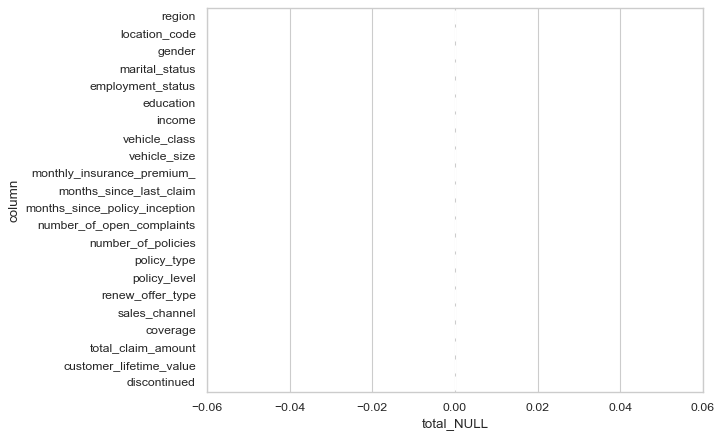

In [445]:
df_null_cols = pl.from_pandas(df_insurance_raw).null_count().to_pandas().T.reset_index()
df_null_cols.columns = ["column", "total_NULL"]
sns.barplot(df_null_cols, y="column", x="total_NULL")
plt.show()

**Inference**

No Nulls and Empty values are present in the given dataset features and it will be easier to carry out the statistical analysis/modeling. not required to eliminate any of observations.

## 2. (A and B) Perform basic descriptive analytics and visualization on the Insurance Dataset and give your inferences for the management to initiate improvement actions.

### Understanding Categorical and  Continous Features.

There are 14 categorical and 8 continous variables are present in the insurance dataset.

**Categoical features:**

In [446]:
df_insurance_raw.select_dtypes("object").head()

,region,location_code,gender,marital_status,employment_status,education,vehicle_class,vehicle_size,policy_type,policy_level,renew_offer_type,sales_channel,coverage,discontinued
0,South,Suburban,M,Married,Retired,College,Four-Door Car,Medsize,Corporate Auto,Corporate L3,Offer1,Agent,Basic,Yes
1,East,Rural,M,Married,Employed,Bachelor,Luxury Car,Small,Personal Auto,Personal L3,Offer1,Agent,Extended,No
2,South,Urban,F,Married,Employed,College,SUV,Small,Personal Auto,Personal L3,Offer3,Branch,Basic,No
3,South,Suburban,M,Married,Retired,High School or Below,Sports Car,Medsize,Personal Auto,Personal L2,Offer1,Web,Basic,Yes
4,East,Suburban,F,Divorced,Disabled,Bachelor,Four-Door Car,Medsize,Corporate Auto,Corporate L3,Offer1,Web,Basic,Yes


**Continous features:**

In [447]:
df_insurance_raw.select_dtypes(["int", "float"]).head()

,income,monthly_insurance_premium_,months_since_last_claim,months_since_policy_inception,number_of_open_complaints,number_of_policies,total_claim_amount,customer_lifetime_value
0,26806,63,32,19,0,2,302.400000,7019
1,35322,244,4,33,0,5,76.826503,19185
2,46855,119,13,94,0,9,472.391125,9501
3,19683,117,17,41,1,9,561.600000,8383
4,19864,63,22,96,0,1,352.394515,2359


### Exploratory Data Analysis.

#### EDA-1: what are the policy type ?

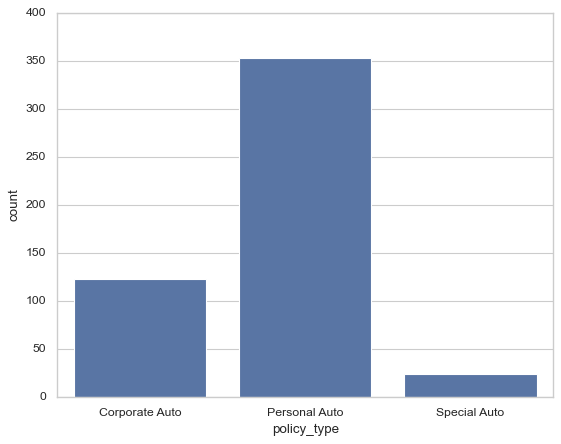

In [448]:
sns.countplot(df_insurance_raw, x="policy_type")
plt.show()

**Inferences**

- Personal Auto policy type propportion is higher than the corporate and special auto.

#### EDA-2: Which type of customers are taking the policies?

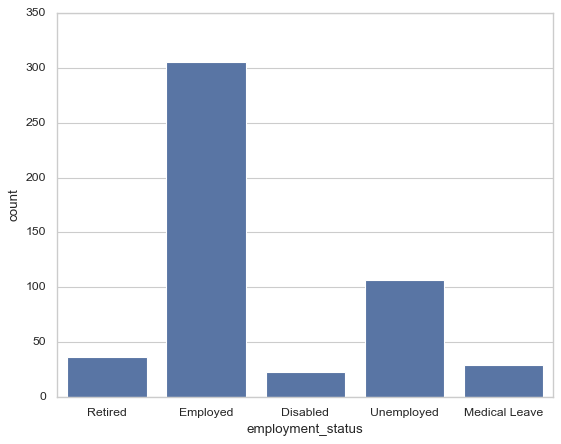

In [449]:
sns.countplot(df_insurance_raw, x="employment_status")
plt.show()

**inferences**

Employeed persons are only taking the pocilies. and there is a tiny contributions from unemployeed group, the remaining retired, disables and medical leave are equally takig the policies.

#### EDA-3: From which region the policies are purchased ?

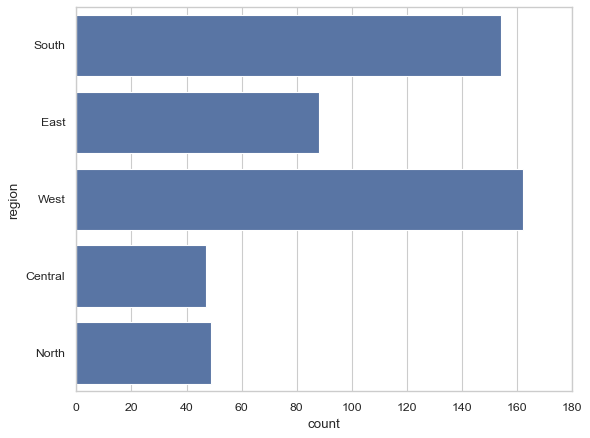

In [450]:
sns.countplot(df_insurance_raw, y="region")
plt.show()

**Inferences**

- South and West

#### EDA-4: Are the rural customers buying more policies than the suburban and urban ?

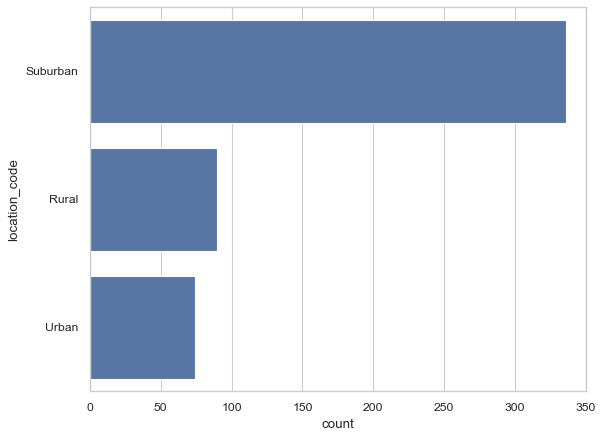

In [451]:
sns.countplot(df_insurance_raw, y="location_code")
plt.show()

**inferences**

- No, Sububran peoples are buying the more policies than Rural.

#### EDA-5: For which type of vehicles customers are taking the policies ?

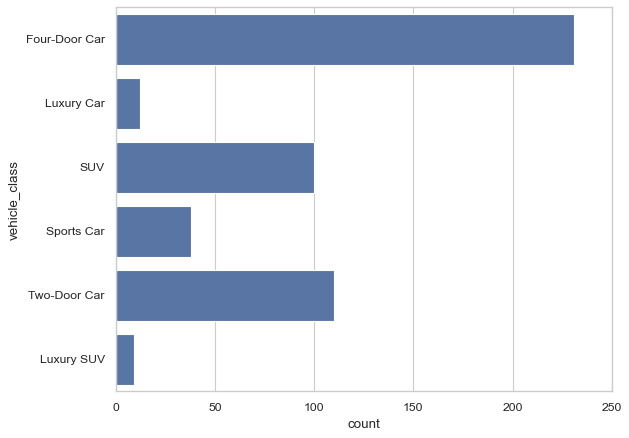

In [452]:
sns.countplot(df_insurance_raw, y="vehicle_class")
plt.show()

**Infeences**

- Customers are preferring to purchase policies for four door and two-door cars

#### EDA-6: Through which channel policy purchases are happening ?

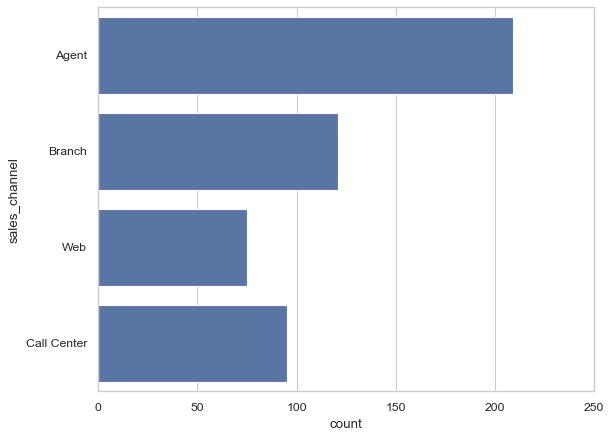

In [453]:
sns.countplot(df_insurance_raw, y="sales_channel")
plt.show()

**Inferences**

- Agents are helping to bring more customers to buy policies

#### EDA-7: Whare are the policy coverage?

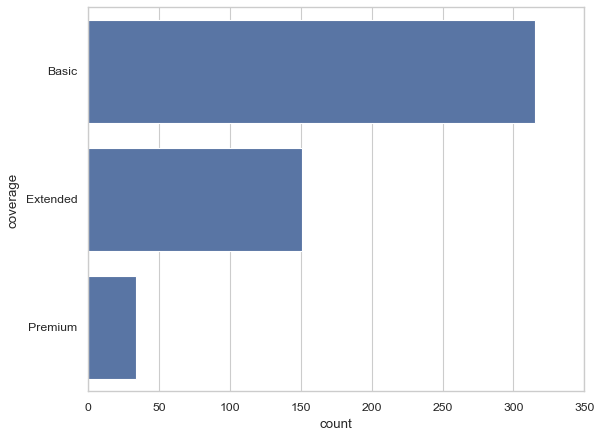

In [454]:
sns.countplot(df_insurance_raw, y="coverage")
plt.show()

**Inferences**

- Customers are taking only basic coverages

#### EDA-8:How many number of customers are discontinued ?

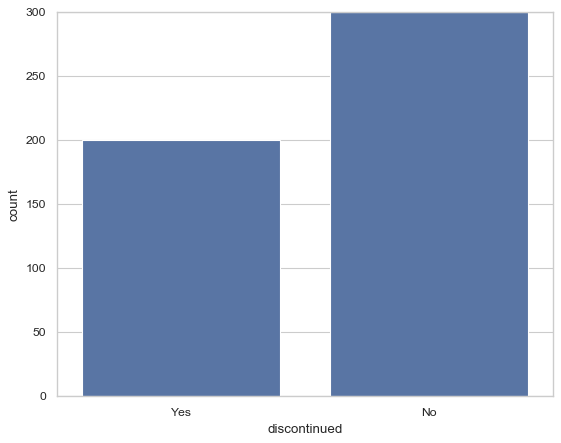

In [455]:
sns.countplot(df_insurance_raw, x="discontinued")
plt.show()

- 40% of customers are discontinued.

#### EDA-9: How are the incomes of customers?

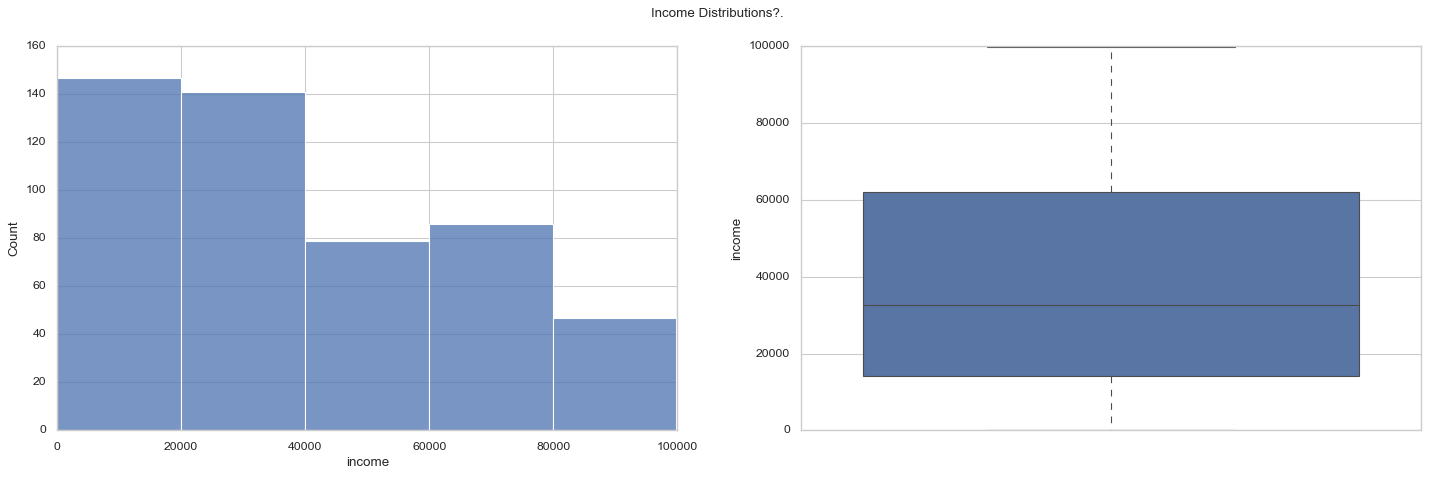

In [456]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, 6))
p1 = sns.histplot(df_insurance_raw["income"], binwidth=20000, ax=ax1)
p2 = sns.boxplot(df_insurance_raw["income"], ax=ax2)
plt.suptitle("Income Distributions?.")
plt.show()

In [457]:
pd.DataFrame(df_insurance_raw["income"].describe()).T

,count,mean,std,min,25%,50%,75%,max
income,500.0,37700.586,29233.9678,0.0,14099.0,32591.0,62142.0,99845.0


**inferences**

1. 50% of customers are falling in the income range of 32K and an average income of customers is 37K, mean is little higher than median as its a right skewed.

#### EDA-10: How are the claim amounts paid to customers?

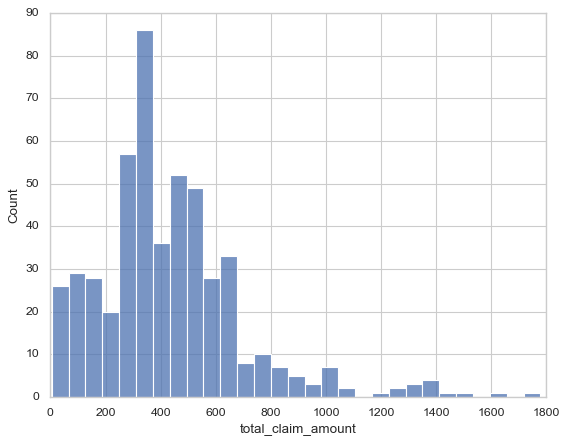

In [458]:
sns.histplot(df_insurance_raw["total_claim_amount"])
plt.show()

In [459]:
pd.DataFrame(df_insurance_raw["total_claim_amount"].describe()).T

,count,mean,std,min,25%,50%,75%,max
total_claim_amount,500.0,429.300851,268.254306,4.845348,291.860184,381.91703,542.4,1778.4


**Inferences**
- 75% of claim amounts are below the prices:545
- There are claims reached out more than 750-1750

#### EDA-11: any relation ship between num of policies hold and claim amounts?

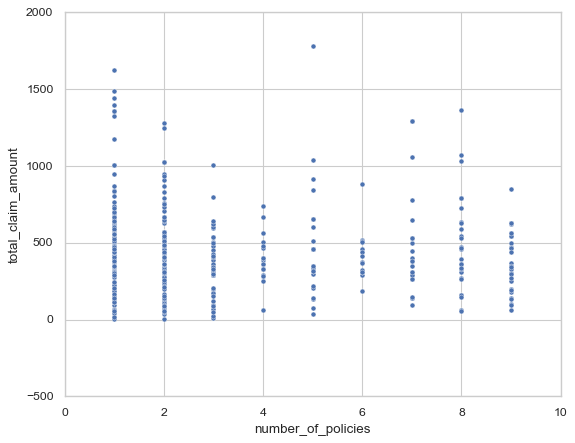

In [460]:
sns.scatterplot(
    df_insurance_raw[["number_of_policies", "total_claim_amount"]],
    x="number_of_policies",
    y="total_claim_amount",
)
plt.show()

**Inferences**

1. No sort of relations, holiding 1 policy's customers are claiming more.

#### EDA-12: Is there any difference i CLTV of contiued and discontinued customers?.

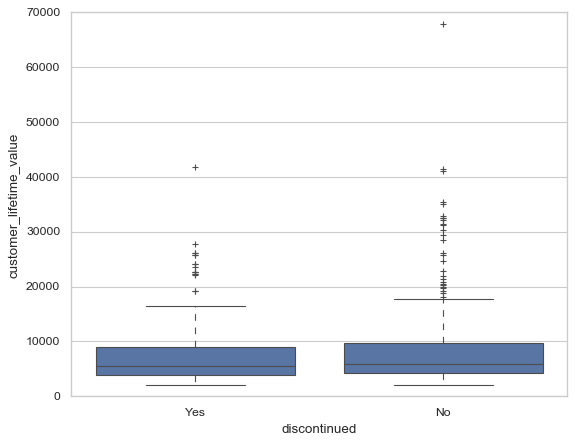

In [461]:
sns.boxplot(df_insurance_raw, x="discontinued", y="customer_lifetime_value")
plt.show()

**Inferences**

Discontinued customers and continued customers lifetime value are differents.

### StatisticalAnalysis-Hypothesis testings.

#### Hypothesis 1:

**Hypothesis**

            Ho: The mean of customer_lifetime_value is 8500
            Ha: The mean of customer_lifetime_value is not 8500

In [462]:
_stat, _pval = ttest_1samp(df_insurance_raw["customer_lifetime_value"], popmean=8500)

print(
    f"P-Value Caluclated is:{round(_pval,3)} which is greater than to 0.05, hence we failed to reject the null hypothesis."
)

P-Value Caluclated is:0.702 which is greater than to 0.05, hence we failed to reject the null hypothesis.


**inferences** 
- The mean value of customer lifetime value is about 8500**

#### Hypothesis 2:

**Hypothesis**

            Ho: There is no difference between mean of customer_lifetime_value contined and discontinued
            Ha: There is a difference between mean of customer_lifetime_value contined and discontinued

In [463]:
df_a = df_insurance_raw[["discontinued", "customer_lifetime_value"]]
_yes = df_a.loc[df_a["discontinued"] == "Yes", "customer_lifetime_value"]
_no = df_a.loc[df_a["discontinued"] == "No", "customer_lifetime_value"]
# Perform 2-sample t-test on male and female ages
_stat, _pval = ttest_ind(_yes, _no)
print(
    f"P-Value Caluclated is:{round(_pval,3)} which is greater than to 0.05, hence we failed to reject the null hypothesis."
)

P-Value Caluclated is:0.151 which is greater than to 0.05, hence we failed to reject the null hypothesis.


**infereces**

We have significant evidence to say that there is no difference between mean of customer_lifetime_value contined and discontinued

#### Hypothesis 3:

**Hypothesis**

            Ho: The true proportion of discontied customers is 40
            Ha: The true proportion of discontied customers is not 40

In [464]:
# Number of satisfied customers
successes = 200
# sample size
trials = 500
# Expected proportion of satisfied customers
hypothesized_proportion = 0.4

# Perform the test
z_statistic, p_value = proportions_ztest(
    count=successes, nobs=trials, value=hypothesized_proportion
)

print(
    f"P-Value Caluclated is:{round(p_value,3)} which is less than to 0.05, hence we can reject the null hypothesis."
)

P-Value Caluclated is:1.0 which is less than to 0.05, hence we can reject the null hypothesis.


**Inferences**
  
- The true proportion of discontined customers is 40%.

#### Hypothesis 4: ChiSuare Associaton test: vehicle_class and Discontinued

**Hypothesis**

            Ho: There is no association between vechicle class and discontinued
            Ha: There is an association between vechicle class and discontinued

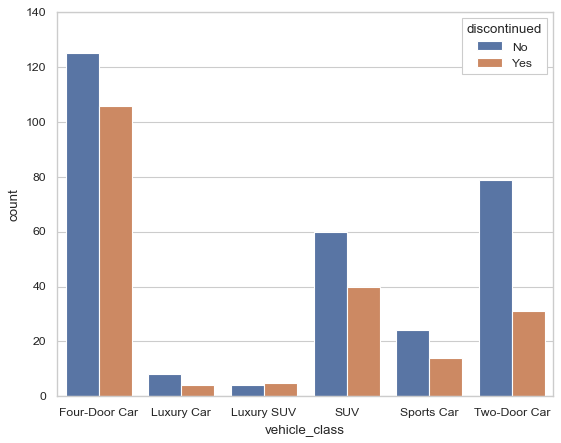

In [465]:
df_3h_agg1 = (
    df_insurance_raw[["vehicle_class", "discontinued"]]
    .groupby(["vehicle_class", "discontinued"])
    .value_counts()
    .reset_index()
)
sns.barplot(df_3h_agg1, x="vehicle_class", y="count", hue="discontinued")
plt.ylabel("count")
plt.show()

In [466]:
## Chi-Square Test-1
df_ecom_CT = (
    pd.crosstab(df_insurance_raw["vehicle_class"], df_insurance_raw["discontinued"])
    .reset_index()
    .drop(["vehicle_class"], axis=1)
)

CS_LVEL = df_ecom_CT.to_numpy()

_chi2, _pvalue, _ddof, _expected = chi2_contingency(CS_LVEL)

get_hypothesis(_pvalue)

P-Value:0.05088 is greater than 0.05 hence we failed to reject the null hypothesis.


**Inferences**
  
- Customer discontinuation rates appear independent of the vehicle class they choose.

## 2.(C AND D): Regression Problem.

**Using CLTV as the target variable perform exploratory analytics to identify the most important features contributing significantly to the variation observed in CLTV.**

**Build 3 most appropriate machine learning algorithms which can be best tried/attempted to build a predictive model for future customers**

### Pre-Modeling Activities: Feature Creation and Encoding and Relationship checks

In [467]:
for _col in df_insurance_raw.select_dtypes("object").columns:
    _lev = len(df_insurance_raw[f"{_col}"].unique())
    print(f"Field:{_col} has levels:{_lev}")

Field:region has levels:5
Field:location_code has levels:3
Field:gender has levels:2
Field:marital_status has levels:3
Field:employment_status has levels:5
Field:education has levels:5
Field:vehicle_class has levels:6
Field:vehicle_size has levels:3
Field:policy_type has levels:3
Field:policy_level has levels:9
Field:renew_offer_type has levels:4
Field:sales_channel has levels:4
Field:coverage has levels:3
Field:discontinued has levels:2


Our dataset contains 14 categorical features, each with more than one level. To encode these features for machine learning analysis, we will employ One-Hot Encoding.

In [468]:
_onehot_encoder = OneHotEncoder(
    variables=[
        "region",
        "location_code",
        "gender",
        "marital_status",
        "employment_status",
        "education",
        "vehicle_class",
        "vehicle_size",
        "policy_type",
        "policy_level",
        "renew_offer_type",
        "sales_channel",
        "coverage",
    ],
    drop_last=True,
)

In [469]:
df_insurance_encoded = _onehot_encoder.fit_transform(df_insurance_raw)

In [470]:
_my = OneHotEncoder(
    variables="discontinued",
    drop_last=False,
)
df_insurance_tidy = _my.fit_transform(df_insurance_encoded)

In [471]:
X_predictors = df_insurance_tidy.drop("customer_lifetime_value", axis=1)
Y_target = df_insurance_tidy["customer_lifetime_value"]

In [472]:
labels = list(X_predictors.columns)

- After one-hot encoding the categorical variables, we now have separate features for each category within those variables. These encoded features, along with the original non-categorical features, will be used to create the X_predictor (features used for prediction) and Y_target (variable to be predicted) for our model.

In [473]:
X_predictors.head()

,income,monthly_insurance_premium_,months_since_last_claim,months_since_policy_inception,number_of_open_complaints,number_of_policies,total_claim_amount,region_South,region_East,region_West,...,renew_offer_type_Offer1,renew_offer_type_Offer3,renew_offer_type_Offer2,sales_channel_Agent,sales_channel_Branch,sales_channel_Web,coverage_Basic,coverage_Extended,discontinued_Yes,discontinued_No
0,26806,63,32,19,0,2,302.400000,1,0,0,...,1,0,0,1,0,0,1,0,1,0
1,35322,244,4,33,0,5,76.826503,0,1,0,...,1,0,0,1,0,0,0,1,0,1
2,46855,119,13,94,0,9,472.391125,1,0,0,...,0,1,0,0,1,0,1,0,0,1
3,19683,117,17,41,1,9,561.600000,1,0,0,...,1,0,0,0,0,1,1,0,1,0
4,19864,63,22,96,0,1,352.394515,0,1,0,...,1,0,0,0,0,1,1,0,1,0


In [474]:
Y_target.head()

0     7019
1    19185
2     9501
3     8383
4     2359
Name: customer_lifetime_value, dtype: int64

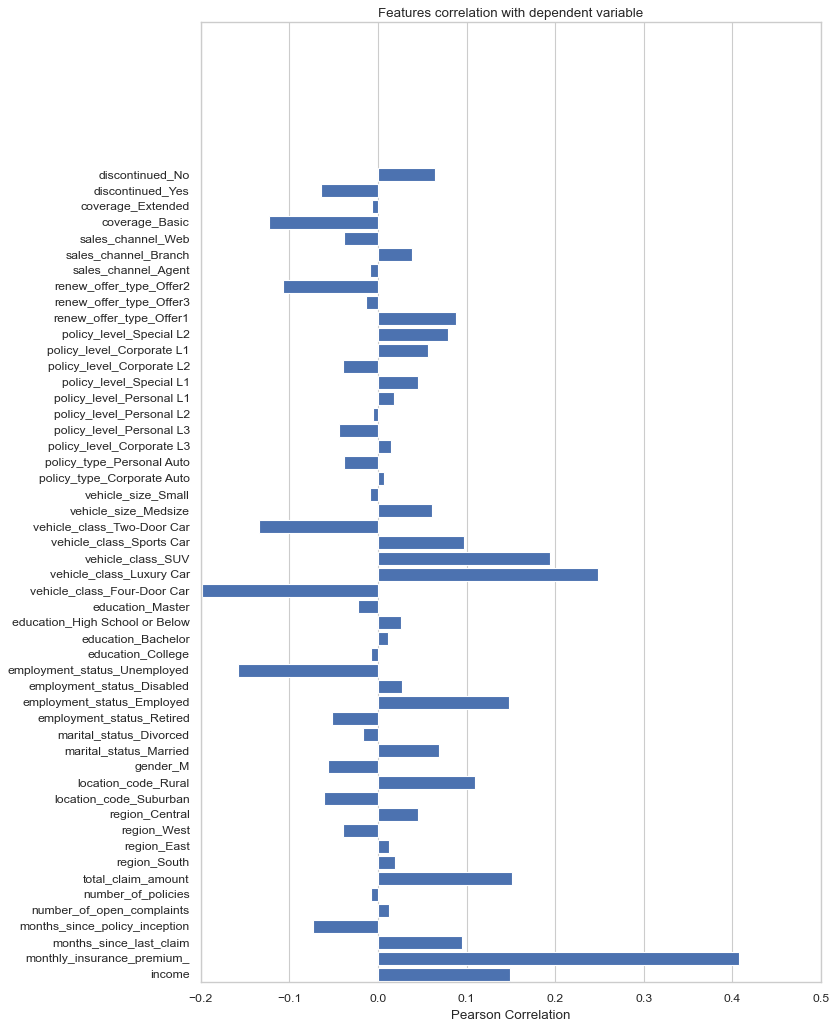

In [475]:
# Create a list of the feature names
features = np.array(X_predictors.columns)
# Instantiate the visualizer
visualizer = FeatureCorrelation(labels=features, size=(800, 1200))
visualizer.fit(X_predictors, Y_target)
visualizer.show()
plt.show()

**Inferences**

- Weak Correlations: The analysis reveals that none of the correlation coefficients between features and the target variable exceed 0.4 in either positive or negative direction. This suggests that no single feature has an extremely strong linear relationship with the target variable.

- Positive Correlations with Target Variable: Among continuous variables, monthly income premium and a luxury vehicle class exhibit the strongest positive correlations with the target variable.

- Negative Correlations with Target Variable: Conversely, unemployment status and having a basic coverage policy are negatively correlated with the target variable. This suggests that being unemployed and having basic coverage are associated with lower values for the target variable.

### Basic Regression modeling.

In [476]:
X = sm.add_constant(X_predictors)
Y = Y_target
_model_spec = sm.OLS(Y, X)
_MODEL_FIT = _model_spec.fit()

#### Model Summary

In [477]:
# print(f"Trial-1#The Regression Table:##\n{_MODEL_FIT.summary2()}")

**Inferences**

1. The R-squared value of 0.29 and Adjusted R-squared of 0.21 suggest that the model explains a portion of the variation in the target variable (Y) that can be predicted by the predictor variables (X). 

#### Regression Model Betas.

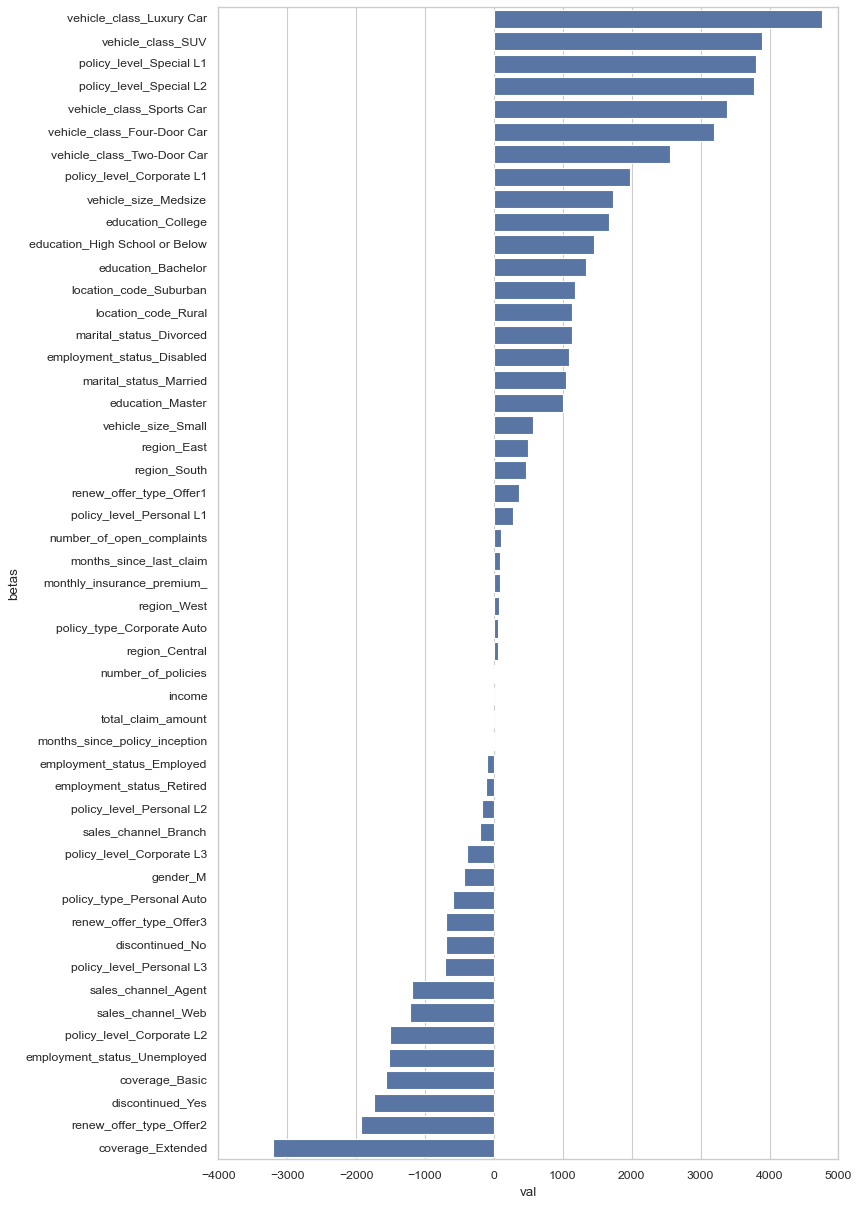

In [478]:
df_Betas_with_alpha = pd.DataFrame(_MODEL_FIT.params).reset_index().iloc[1:, :]
df_Betas_with_alpha.columns = ["betas", "val"]
df_Betas_with_SE = (
    pd.concat([_MODEL_FIT.params, _MODEL_FIT.bse], axis=1).reset_index().iloc[1:, :]
)
df_Betas_with_SE.columns = ["betas", "val", "se_"]
fig, ax = plt.subplots(figsize=(10, 18))
sns.barplot(
    y="betas", x="val", data=df_Betas_with_SE.sort_values("val", ascending=False)
)
plt.show()

**Inferences**

- The beta coefficients for half of the predictor variables are negative. In other words, a one-unit increase in these variables is likely to lead to a decrease in the value of the response variable, but the magnitude of that decrease is not specified here.

#### VIF.

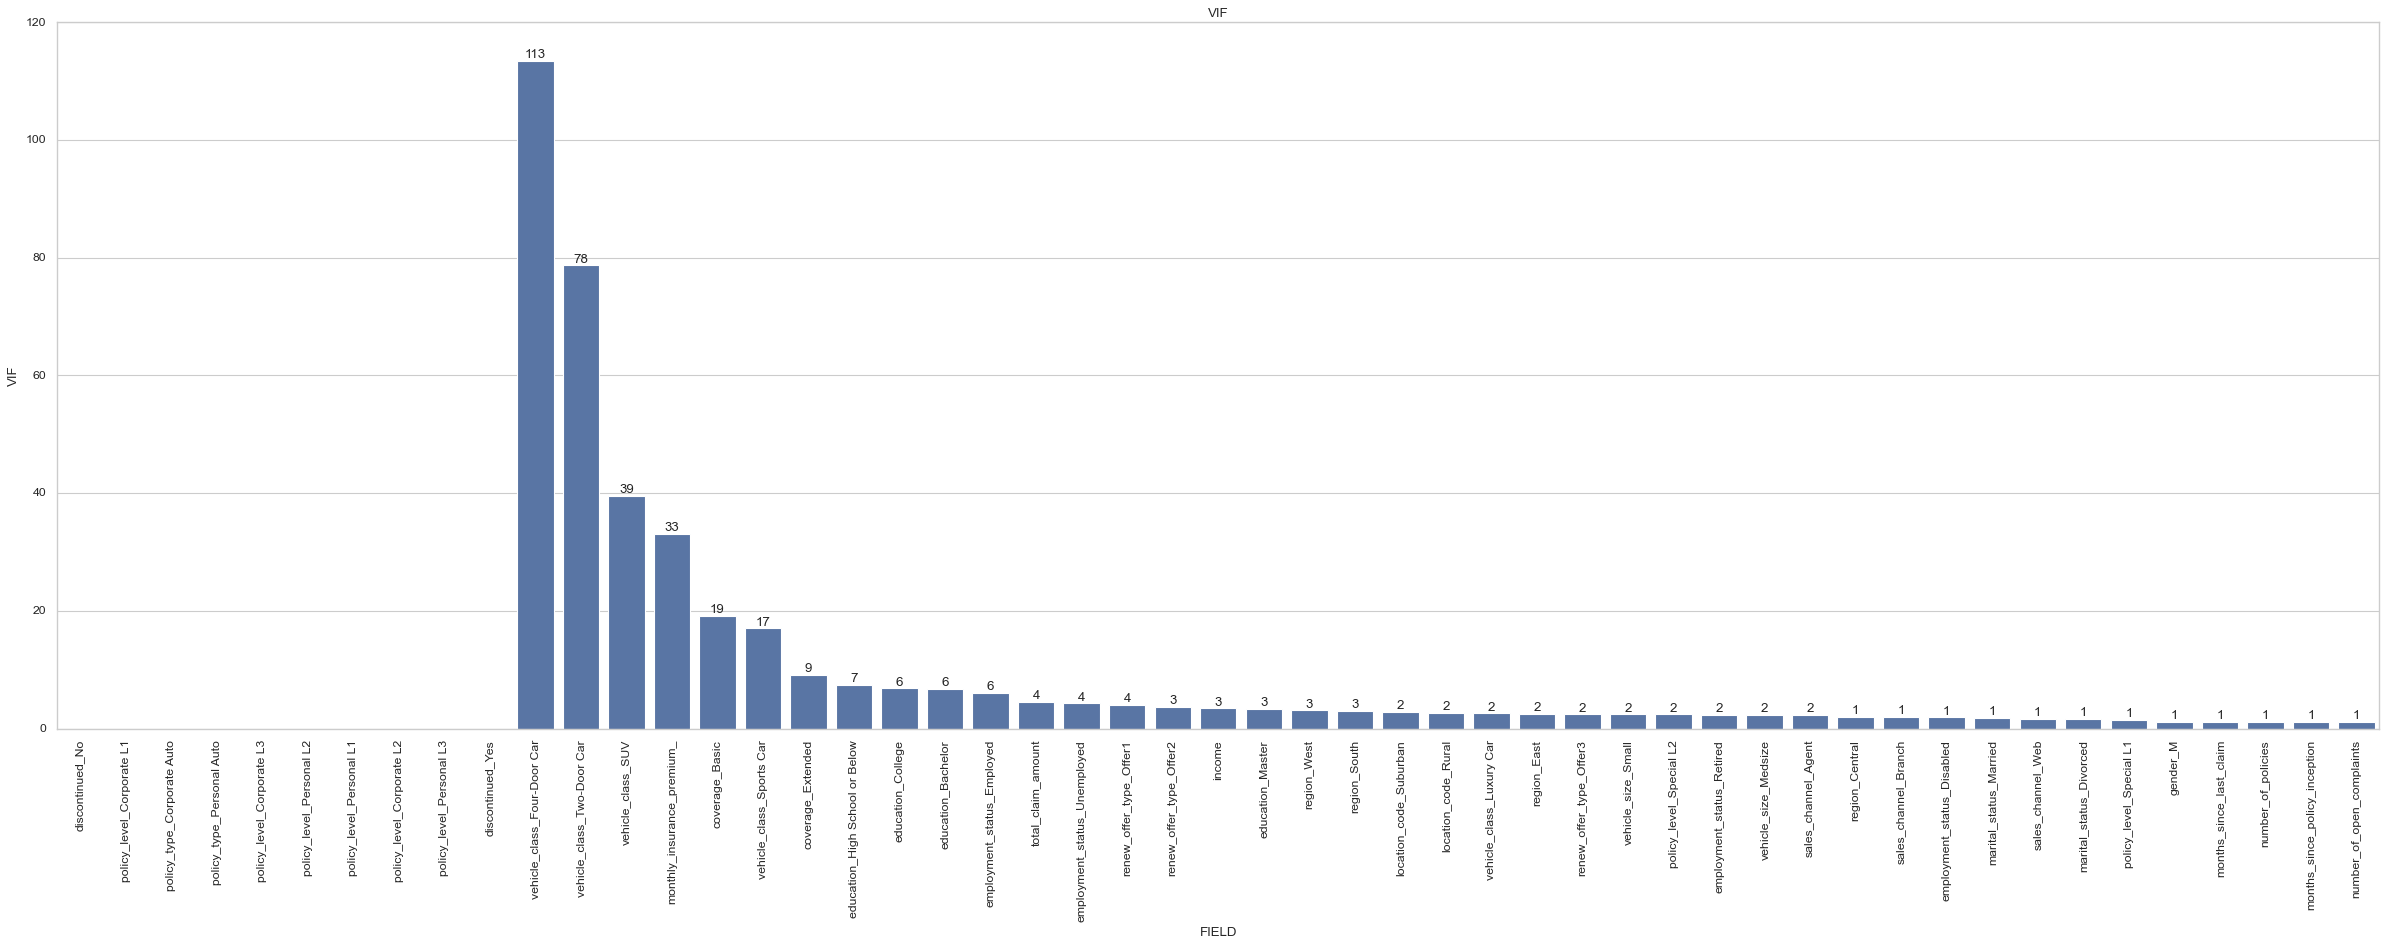

In [479]:
custom_VIF(_model_spec)

In [480]:
var_names = _model_spec.exog_names
X = _model_spec.exog
_limit = X.shape[1]
vif_dict = {}
for idx in range(_limit):
    vif = round(sm_oi.variance_inflation_factor(X, idx), 5)
    vif_dict[var_names[idx]] = vif
_DF = pd.DataFrame([vif_dict]).T
_DF.columns = ["VIF"]
_DF = _DF.reset_index()
df_sorted = _DF.iloc[1:].sort_values(by="VIF", ascending=False)

**Features having VIF values below 5.**

In [481]:
df_sorted.iloc[:21]

,index,VIF
51,discontinued_No,inf
40,policy_level_Corporate L1,inf
32,policy_type_Corporate Auto,inf
33,policy_type_Personal Auto,inf
34,policy_level_Corporate L3,inf
36,policy_level_Personal L2,inf
37,policy_level_Personal L1,inf
39,policy_level_Corporate L2,inf
35,policy_level_Personal L3,inf
50,discontinued_Yes,inf


**Features having VIF values greater than or equal to 5 .**

In [482]:
df_sorted.iloc[21:]

,index,VIF
7,total_claim_amount,4.46738
20,employment_status_Unemployed,4.28022
42,renew_offer_type_Offer1,4.08476
44,renew_offer_type_Offer2,3.70694
1,income,3.42983
24,education_Master,3.27873
10,region_West,3.07734
8,region_South,3.00389
12,location_code_Suburban,2.78891
13,location_code_Rural,2.60509


### Pre-Modeling Activities: Train/Test validation sets creations and Feature Scaling/Standardization.

In [483]:
X_train, X_test, y_train, y_test = train_test_split(
    X_predictors, Y_target, test_size=0.2, random_state=2024
)

**Train/Test Validation**

In statistical modeling, a crucial step involves assessing how well a model performs on unseen data. 

- This is achieved by splitting the data into two sets: 
       a training set and a testing set. 
- The model is trained on the training set, allowing it to learn the underlying relationships within the data. Subsequently, the model's performance is evaluated on the completely separate testing set.
  
- This train-test split approach is a well-established technique to ensure a model's generalizability, meaning its ability to perform well on new, unseen data that wasn't used for training.

- for this analysis i'm using 80-20 trin/test split approch as follows.

In [484]:
print(f"Trainset:{X_train.shape} and testing:{X_test.shape}")

Trainset:(400, 51) and testing:(100, 51)


In [485]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

**StandardScaler for Effective Scaling**

- In machine learning algorithms, the scale of our input data can significantly impact the training process and ultimately the model's performance. This is because many algorithms rely on the distances or magnitudes between data points to make predictions.
  
- If features have vastly different scales (e.g., one feature has values ranging from 0 to 10, while another ranges from 1000 to 5000), algorithms like Support Vector Machines (SVM) or k-Nearest Neighbors (k-NN) can be misled. Features with larger scales might dominate the distance calculations, even if they aren't as predictive as features with smaller scales.

- To address this issue and ensure all features contribute equally to the model's learning process, This technique performs standardization, which transforms each feature by subtracting the mean and dividing by the standard deviation. The result is a new set of features where:

          The mean is 0 (centered around the mean)
          The standard deviation is 1 (normalized)

- By applying standardization, all features are placed on a common scale, ensuring that algorithms treat them with equal importance during training.

- I applied standard scaling to the data before using machine learning algorithms.

### Experiments:Supervised MachineLearning Models.

#### Linear Regression.

In [486]:
linear_reg_spec = LinearRegression()
linear_reg_spec.fit(X_train, y_train)
los_preds_tr = linear_reg_spec.predict(X_train)
los_preds_tes = linear_reg_spec.predict(X_test)

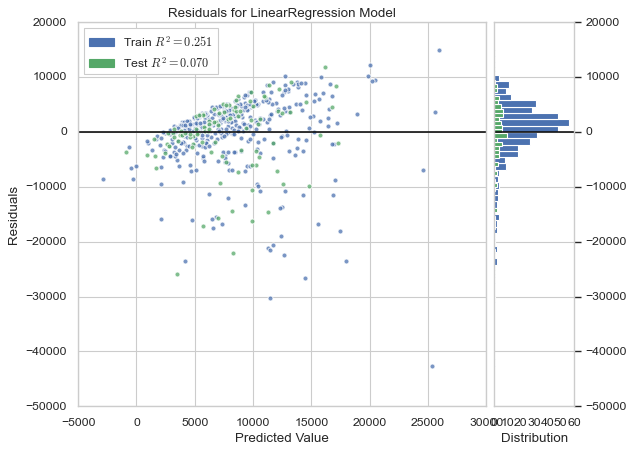

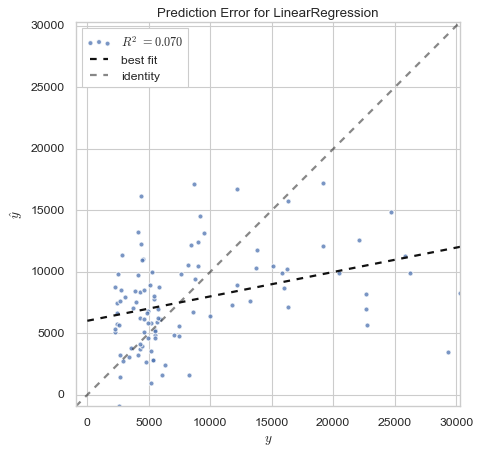

In [487]:
custom_regression_resid_predict_plot(linear_reg_spec, X_train, y_train, X_test, y_test)

**Inferences**

- The R-squared values for the training set (0.25) and testing set (0.07) indicate a significant difference in the model's performance between the data it was trained on and unseen data. This suggests that the model might be overfitting the training data, leading to a good fit on that specific data but poor generalizability to new data

#### Decision Trees.

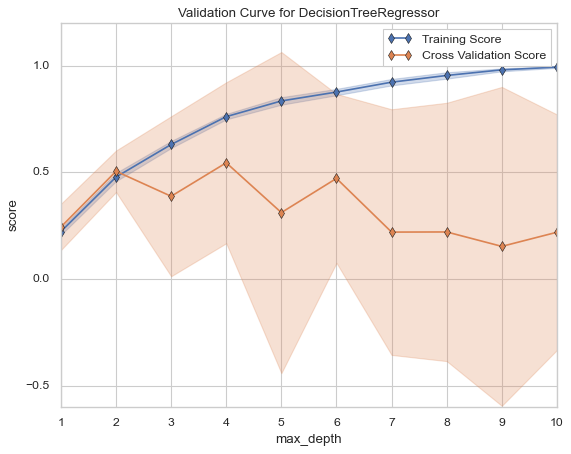

In [488]:
viz = ValidationCurve(
    DecisionTreeRegressor(),
    param_name="max_depth",
    param_range=np.arange(1, 11),
    cv=10,
    scoring="r2",
)

# Fit and show the visualizer
viz.fit(X_train, y_train)
viz.show()
plt.show()

In [489]:
_model_spec_DT_reg = DecisionTreeRegressor(max_depth=2)

In [490]:
_model_spec_DT_reg.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=2)

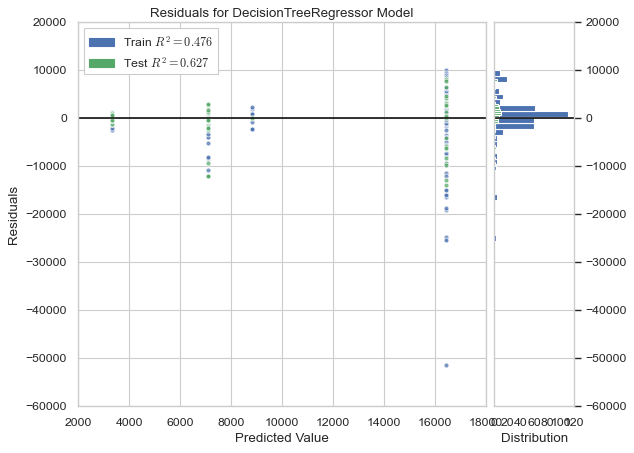

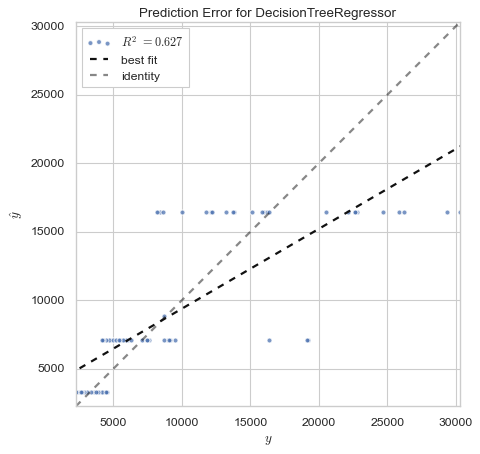

In [491]:
custom_regression_resid_predict_plot(
    _model_spec_DT_reg, X_train, y_train, X_test, y_test
)

**Inferences**

- The R-squared values of 0.47 for the training set and 0.62 for the testing set are interesting. While a higher testing R-squared (0.62) might seem positive, it's important to consider that a good model typically exhibits a similar or slightly lower R-squared on the testing set compared to the training set.

- In our case, the training R-squared (0.47) suggests we could do improvement in the model's ability to learn from the training data. Further investigation such as feature selection, addressing potential biases could be beneficial.

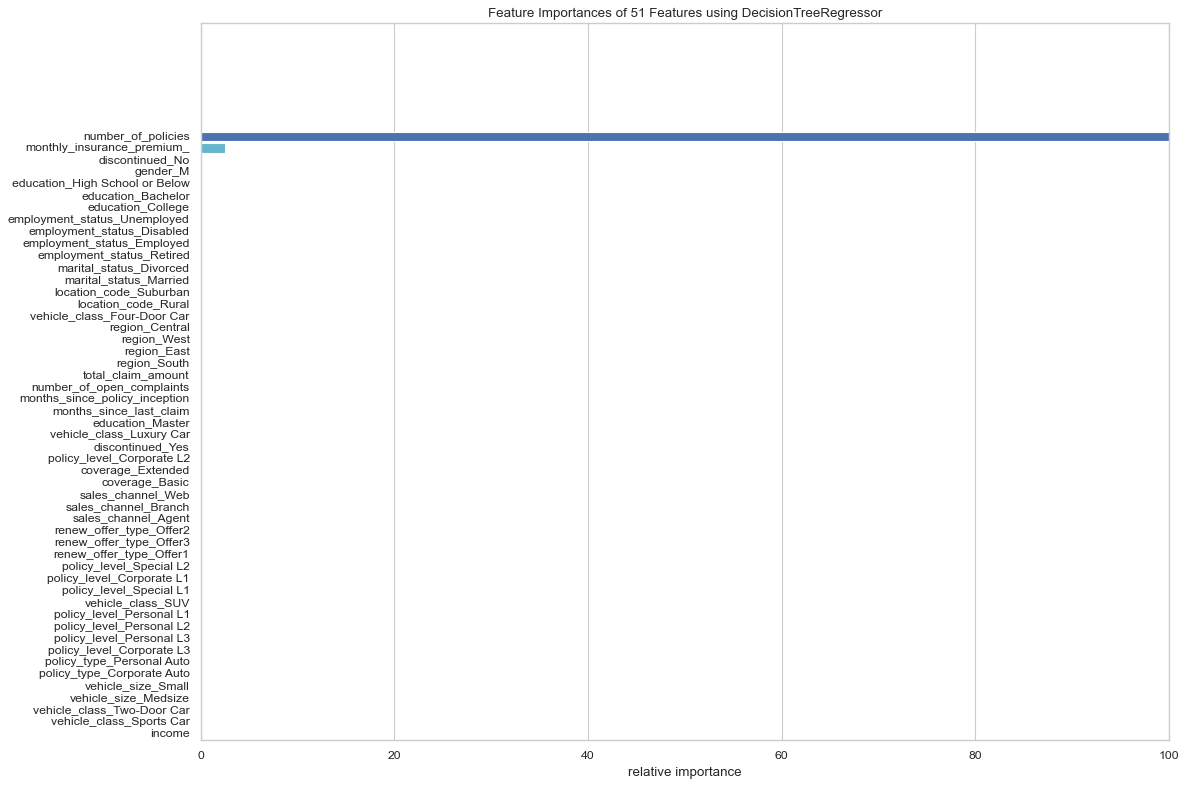

In [492]:
viz = FeatureImportances(_model_spec_DT_reg, labels=labels, size=(1200, 800))
viz.fit(X_train, y_train)
viz.show()
plt.show()

- DecisionTrees Feature Importance gives us only 2 variables are having relative importance as showed in the above plot such as number of policies and monthly insurance premium.

#### RandomForest.

In [493]:
_model_spec_RF_REG = RandomForestRegressor(random_state=2024)

In [494]:
# Define the parameter grid
param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [10, 20, 30],
    # 'min_samples_split': [2, 5, 10, 15],
    # 'min_samples_leaf': [1, 2, 4, 8],
    "max_features": [2, 5, 8, 12, 15, 17, 21],
}

# Create the random forest classifier
rf = RandomForestRegressor()

# Use GridSearchCV or RandomizedSearchCV
grid_search = GridSearchCV(rf, param_grid, cv=3, scoring="r2")

# Fit the grid search to your data
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [10, 20, 30],
                         'max_features': [2, 5, 8, 12, 15, 17, 21],
                         'n_estimators': [100, 200]},
             scoring='r2')

In [495]:
_model_spec_RF_REG = RandomForestRegressor(
    random_state=2024, max_depth=10, max_features=21, n_estimators=100
)
_model_spec_RF_REG.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, max_features=21, random_state=2024)

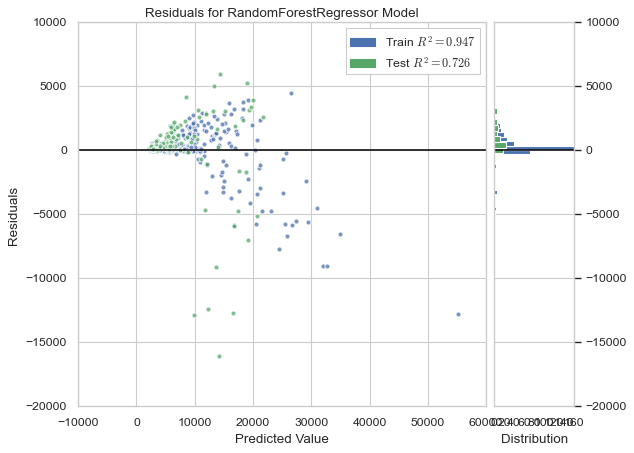

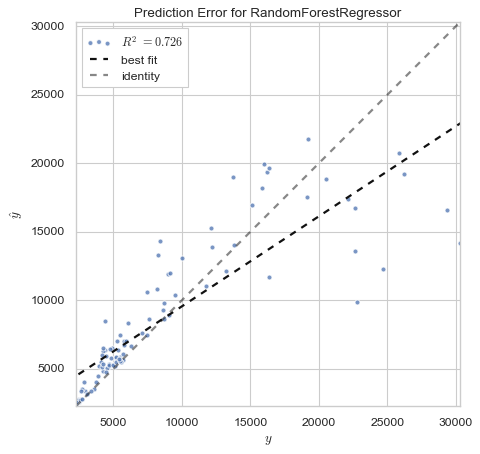

In [496]:
custom_regression_resid_predict_plot(
    _model_spec_RF_REG, X_train, y_train, X_test, y_test
)

**Inferences**

- The training and testing R-squared scores (0.94 and 0.72, respectively) reveal a substantial difference in performance, suggesting the model may be overfitting the training data. 


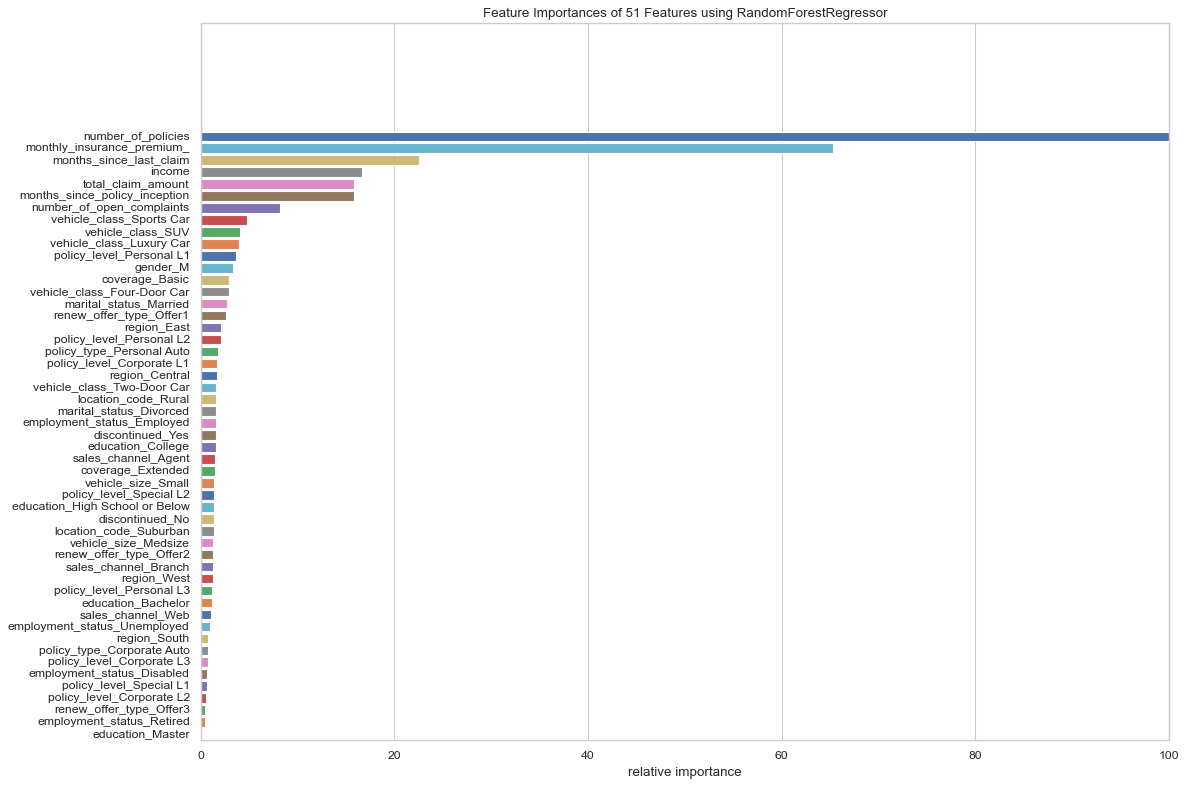

In [497]:
viz = FeatureImportances(_model_spec_RF_REG, labels=labels, size=(1200, 800))
viz.fit(X_train, y_train)
viz.show()
plt.show()

In [498]:
_FEAT = pd.DataFrame(
    {"feature": viz.features_, "importance_": viz.feature_importances_}
).sort_values("importance_", ascending=False)

In [499]:
_FEAT = _FEAT[_FEAT["importance_"] > 2.6]

**Randomforest Regression suggests the below are the potential predictiors to predict the targe variables.**

In [500]:
list(_FEAT["feature"])

['number_of_policies',
 'monthly_insurance_premium_',
 'months_since_last_claim',
 'income',
 'total_claim_amount',
 'months_since_policy_inception',
 'number_of_open_complaints',
 'vehicle_class_Sports Car',
 'vehicle_class_SUV',
 'vehicle_class_Luxury Car',
 'policy_level_Personal L1',
 'gender_M',
 'coverage_Basic',
 'vehicle_class_Four-Door Car',
 'marital_status_Married',
 'renew_offer_type_Offer1']

**To gain a deeper understanding of the relationships between specific features and the target variable, I plan to create a new dataset containing only the following variables listed above and  I will then conduct experiments using various regression models to assess their effectiveness in predicting the target variable based on this subset of data.**

In [501]:
X_predictors_sel = X_predictors[list(_FEAT["feature"])]

#### Data with subset of predictors.

In [502]:
X_train, X_test, y_train, y_test = train_test_split(
    X_predictors_sel, Y_target, test_size=0.2, random_state=2024
)

In [503]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [504]:
print(f"Trainset:{X_train.shape} and testing:{X_test.shape}")
labels = list(X_predictors_sel.columns)

Trainset:(400, 16) and testing:(100, 16)


- As we can see in the subset of data we do have only 16 predictors.

#### Experiment-2: DecisionTrees

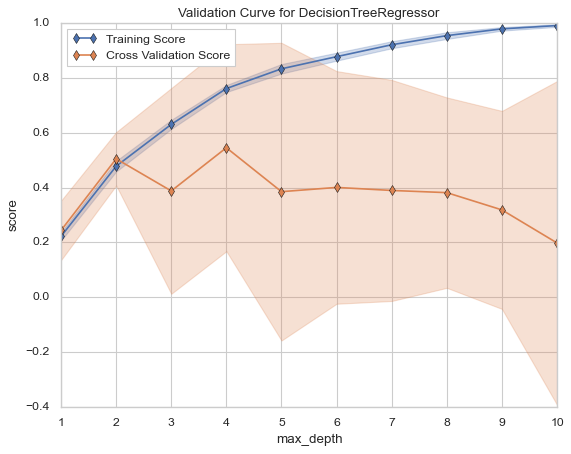

In [505]:
viz = ValidationCurve(
    DecisionTreeRegressor(),
    param_name="max_depth",
    param_range=np.arange(1, 11),
    cv=10,
    scoring="r2",
)

# Fit and show the visualizer
viz.fit(X_train, y_train)
viz.show()
plt.show()

In [506]:
_model_spec_DT_reg = DecisionTreeRegressor(max_depth=2)

In [507]:
_model_spec_DT_reg.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=2)

In [508]:
los_preds_dt_train = _model_spec_DT_reg.predict(X_train)
los_preds_dt_test =_model_spec_DT_reg.predict(X_test)

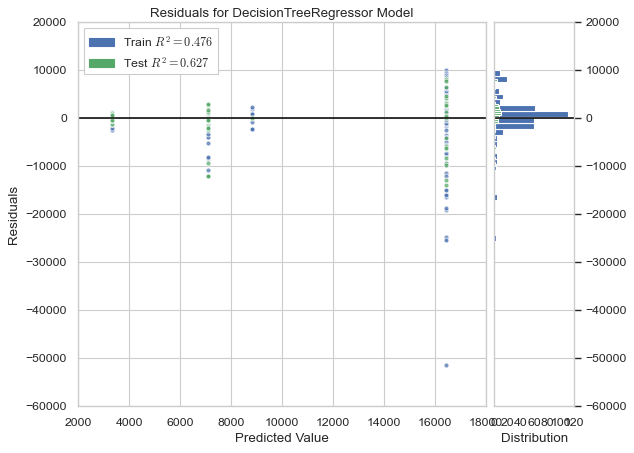

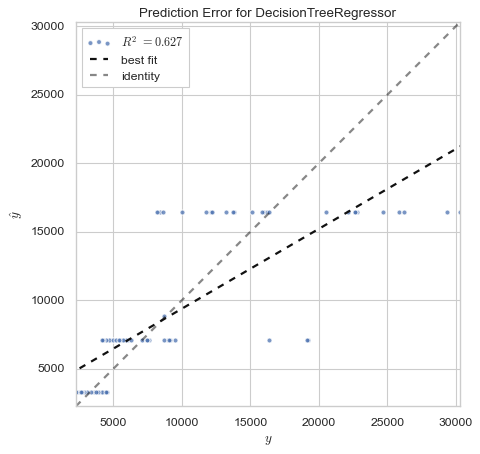

In [509]:
custom_regression_resid_predict_plot(
    _model_spec_DT_reg, X_train, y_train, X_test, y_test
)

**Inferences**

- The training R-squared (0.47) and testing R-squared (0.62) are similar to our previous results, even after removing features from the dataset. This suggests that decision trees are still capturing important patterns in the data, even without all the original features.

#### Experiment-2: RandomForest

In [510]:
_model_spec_RF_REG = RandomForestRegressor(
    random_state=2024, max_depth=30, max_features=15, n_estimators=200
)
_model_spec_RF_REG.fit(X_train, y_train)

RandomForestRegressor(max_depth=30, max_features=15, n_estimators=200,
                      random_state=2024)

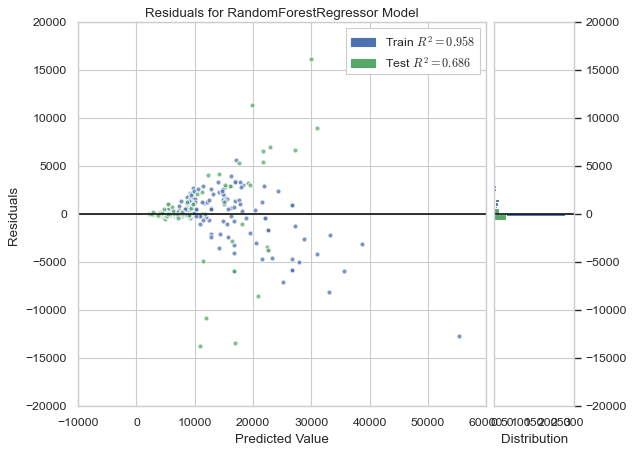

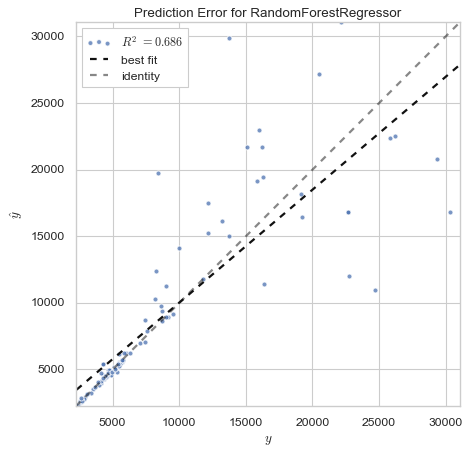

In [511]:
custom_regression_resid_predict_plot(
    _model_spec_RF_REG, X_train, y_train, X_test, y_test
)

**Inferences**
- While training and testing R-squared aren't directly comparable, the current model still seems overfitted. This is because the testing R-squared remains high even after removing irrelevant features from the random forest.

#### Experiment-2: LinearRegression

In [512]:
linear_reg_spec = LinearRegression()
linear_reg_spec.fit(X_train, y_train)
los_preds_tr = linear_reg_spec.predict(X_train)
los_preds_tes = linear_reg_spec.predict(X_test)

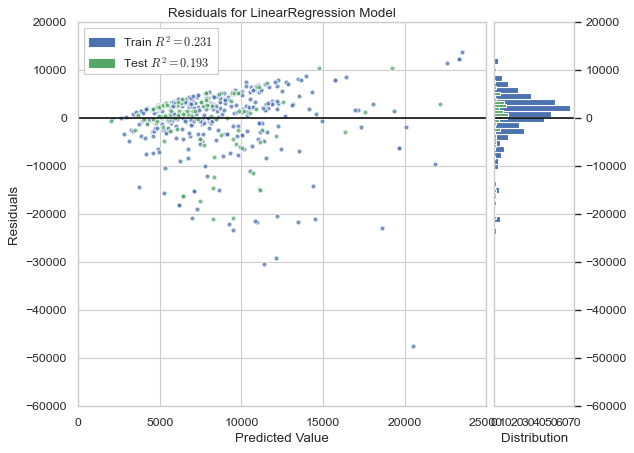

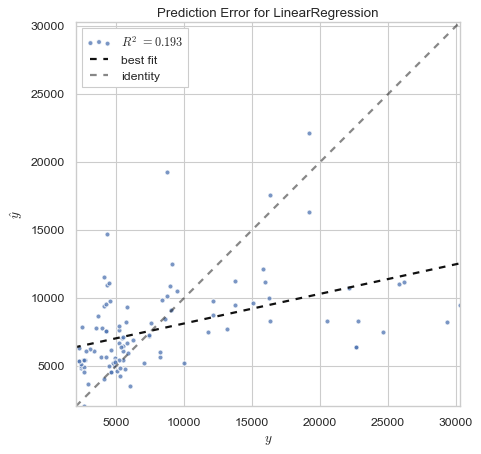

In [513]:
custom_regression_resid_predict_plot(linear_reg_spec, X_train, y_train, X_test, y_test)

**Inferences**

- Both the original model (without feature removal) and the current model (with feature removal) achieved similar R-squared values in training (0.23) and testing (0.19).

#### Experiment-2: Boosting-Regression

In [514]:
param_grid = {
    "n_estimators": hp.quniform("n_estimators", 200, 2500, 100),
    "max_depth": hp.quniform("max_depth", 1, 10, 1),
    "learning_rate": hp.loguniform("learning_rate", np.log(0.001), np.log(1)),
    "booster": hp.choice("booster", ["gbtree", "dart"]),
    "gamma": hp.loguniform("gamma", np.log(0.01), np.log(10)),
    "subsample": hp.uniform("subsample", 0.50, 0.90),
    "colsample_bytree": hp.uniform("colsample_bytree", 0.50, 0.99),
    "colsample_bylevel": hp.uniform("colsample_bylevel", 0.50, 0.99),
    "colsample_bynode": hp.uniform("colsample_bynode", 0.50, 0.99),
    "reg_lambda": hp.uniform("reg_lambda", 1, 20),
}

def objective(params):

    # we need a dictionary to indicate which value from the space
    # to attribute to each value of the hyperparameter in the xgb
    params_dict = {
        # important int, as it takes integers only
        "n_estimators": int(params["n_estimators"]),
        # important int, as it takes integers only
        "max_depth": int(params["max_depth"]),
        "learning_rate": params["learning_rate"],
        "booster": params["booster"],
        "gamma": params["gamma"],
        "subsample": params["subsample"],
        "colsample_bytree": params["colsample_bytree"],
        "colsample_bylevel": params["colsample_bylevel"],
        "colsample_bynode": params["colsample_bynode"],
        "random_state": 1000,
    }

    # with ** we pass the items in the dictionary as parameters
    # to the xgb
    gbm = xgb.XGBRFRegressor(**params_dict)

    # train with cv
    score = cross_val_score(gbm, X_train, y_train, scoring="r2", cv=3, n_jobs=4).mean()

    # to minimize, we negate the score
    return -score

In [515]:
# random_search = fmin(
#     fn=objective,
#     space=param_grid,
#     max_evals=50,
#     rstate=np.random.default_rng(2024),
#     algo=rand.suggest,  # randomized search
# )

In [516]:
# {'booster': 0,
#  'colsample_bylevel': 0.8049403095842097,
#  'colsample_bynode': 0.9831360208702888,
#  'colsample_bytree': 0.6266590323014749,
#  'gamma': 1.494561968586083,
#  'learning_rate': 0.8007241876828338,
#  'max_depth': 6.0,
#  'n_estimators': 2200.0,
#  'reg_lambda': 4.576754746598313,
#  'subsample': 0.6988738316413677}

In [517]:
_XGB_REG_spec_tuned = xgb.XGBRFRegressor(
    gamma=1.5,
    learning_rate=0.8,
    max_depth=6,
    n_estimators=2200,
    reg_lambda=4.5,
    subsample=0.69,
    colsample_bylevel=0.8,
    colsample_bynode=0.98,
    colsample_bytree=0.62,
)

In [518]:
_XGB_REG_spec_tuned.fit(X_train, y_train)

XGBRFRegressor(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=0.8, colsample_bynode=0.98,
               colsample_bytree=0.62, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               gamma=1.5, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=0.8, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=6, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estimators=2200, n_jobs=None,
               num_parallel_tree=None, objective='reg:squarederror', ...)

In [519]:
los_pred_xgb_train=_XGB_REG_spec_tuned.predict(X_train)
los_pred_xgb_test=_XGB_REG_spec_tuned.predict(X_test)

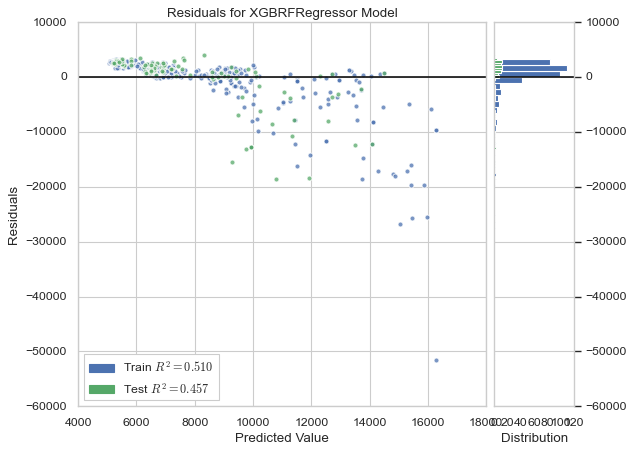

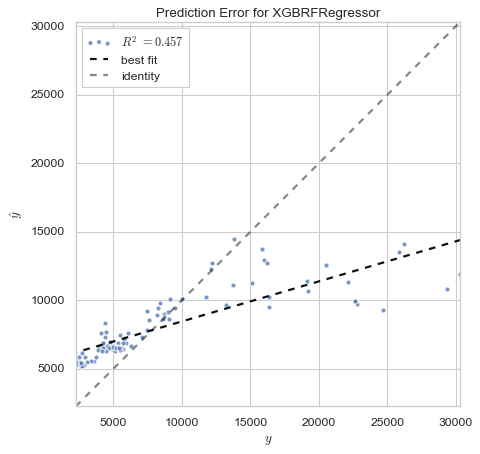

In [520]:
custom_regression_resid_predict_plot(
    _XGB_REG_spec_tuned, X_train, y_train, X_test, y_test
)

**Infereces**

- The XGBRegressor achieved a training R-squared of 0.51 and a testing R-squared of 0.45. This performance suggests it might be a better choice compared to the other 3 models.

I will also take a look at other metrics such as MAE, RMSE of these models and see.

#### Regression Conclusion

**The table summarizes the performance of two different machine learning models (XGBoost and Trees) on a regression task. The table shows the R-Squared, Mean Squared Error (MSE), Mean Absolute Error (MAE), and Root Mean Squared Error (RMSE) for both the training and testing sets of each model.**

In [521]:
# custom_regression_metrics('XGB-Training',y_train,los_pred_xgb_train)
# custom_regression_metrics('XGB-Testing',y_test,los_pred_xgb_test)
# custom_regression_metrics('DT-Training',y_train,los_preds_dt_train)
# custom_regression_metrics('DT-Testing',y_test,los_preds_dt_test)

|Model|Type|R-Squared|MSE|MAE|RMSE|
|-----|----|---------|---|---|----|
|xgb|traininig|0.50|273333475.39|2697.63|5228.14|
|xgb|testing|0.45|24882119.63|3223.14|4988.19|
|Trees|traininig|0.47644|29179327.39|3001.25|5401.78|
|Tress|testing|0.62|17118030.90|2748.26|4137.39|

Here's a breakdown of the metrics for each model:

**_XGBoost:_**

**Training:** XGBoost achieved a training R-Squared of 0.50, which indicates a moderately good fit on the training data. The MSE is 273,333,475.39, the MAE is 2,697.63, and the RMSE is 5,228.14. These values suggest that the model is able to capture some of the underlying patterns in the training data, but there is still some room for improvement.

**Testing:** The testing R-Squared is 0.45, which is lower than the training R-Squared. This suggests that the model may be overfitting the training data to some extent. The MSE is 248,821,196.30, the MAE is 3,223.14, and the RMSE is 4,988.19. These values are all slightly lower than the corresponding values for the training set, but the overall trend suggests that the model may not generalize well to unseen data.

**_Trees:_**

**Training:** The Trees model achieved a training R-Squared of 0.476, which is slightly lower than the training R-Squared of XGBoost. The MSE is 291,793,273.39, the MAE is 3,001.25, and the RMSE is 5,401.78. These values suggest that the Trees model may be slightly less accurate than XGBoost on the training data.

**Testing:** Surprisingly, the Trees model achieved a higher testing R-Squared of 0.62 compared to XGBoost. This could be an indication of overfitting on the training data for XGBoost or underfitting for Trees. The MSE is 171,180,309.00, the MAE is 2,748.26, and the RMSE is 4,137.39. These values are all lower than the corresponding values for both the training set and the XGBoost testing set. This suggests that the Trees model may be generalizing better to unseen data.

## 2.(E AND F): Classification Problem.

In [522]:
from sklearn import preprocessing
from sklearn import utils
X_predictors = df_insurance_encoded.drop(['discontinued'],axis=1)
Y_target = df_insurance_encoded['discontinued']
lab_enc = preprocessing.LabelEncoder()
encoded = lab_enc.fit_transform(Y_target)

In [523]:
X_train, X_test, y_train, y_test = train_test_split(
    X_predictors, encoded, test_size=0.2, random_state=0
)

In [524]:
print(f'Trainset:{X_train.shape} and testing:{X_test.shape}')

Trainset:(400, 50) and testing:(100, 50)


In [525]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

#### LogisticRgression

In [526]:
_model_LR_A = LogisticRegression(random_state=2024)

In [527]:
_model_LR_A.fit(X_train, y_train)

LogisticRegression(random_state=2024)

In [528]:
los_tr_preds_A = _model_LR_A.predict(X_train)
los_tes_preds_A = _model_LR_A.predict(X_test)

--------------------------------------
Logistic-training:ConfusionMatrix and ROC-AUC Curve
--------------------------------------


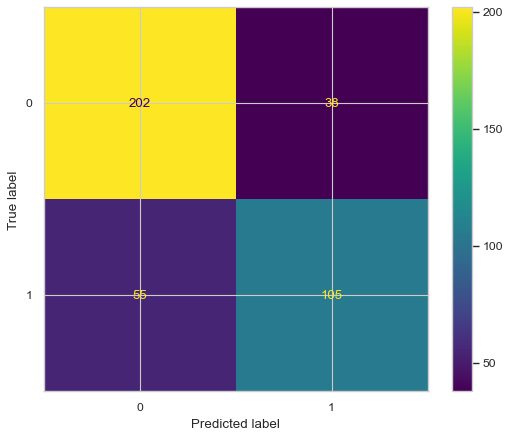

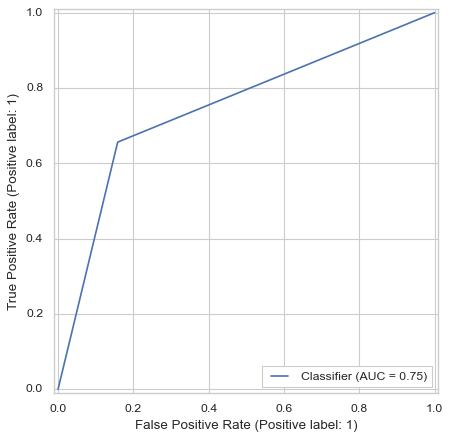

,Accuracy,ROC-AUC,F1-Score,Precision,Recall
Logistic-training,0.7675,0.74896,0.69307,0.73427,0.65625


In [529]:
custom_classification_metrics_report('Logistic-training',y_train, los_tr_preds_A)

--------------------------------------
LogisticRegression-Testing::ConfusionMatrix and ROC-AUC Curve
--------------------------------------


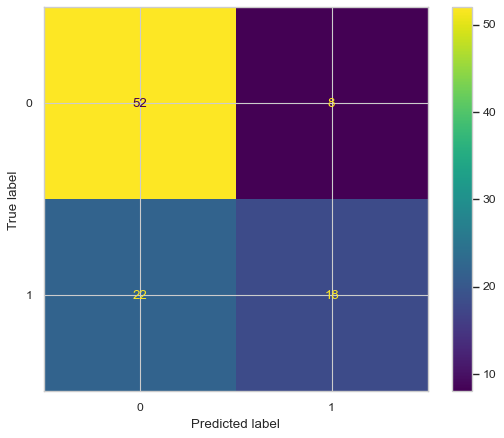

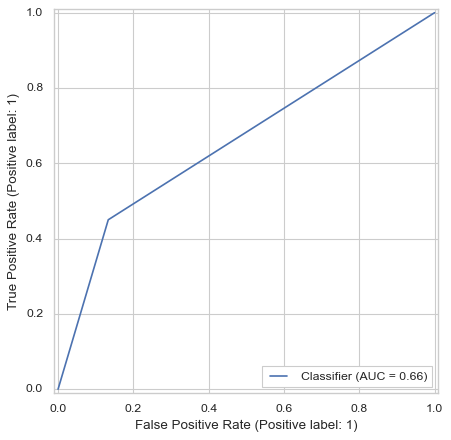

,Accuracy,ROC-AUC,F1-Score,Precision,Recall
LogisticRegression-Testing:,0.7,0.65833,0.54545,0.69231,0.45


In [530]:
custom_classification_metrics_report(
    "LogisticRegression-Testing:", y_test, los_tes_preds_A
)

#### DecisionTrees-Classification

In [531]:
## create a decisiont tree and fit it to the training data
_model_DT_B = DecisionTreeClassifier(random_state=42)
_model_DT_B.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [532]:
los_tr_preds_B = _model_DT_B.predict(X_train)
los_tes_preds_B = _model_DT_B.predict(X_test)

##### Cost Complexity Pruning.

In [533]:
path = _model_DT_B.cost_complexity_pruning_path(
    X_train, y_train
)  # determine values for alpha
ccp_alphas = path.ccp_alphas  # extract different values for alpha
ccp_alphas = ccp_alphas[:-1]  # exclude the maximum value for alpha

clf_dts = []  # create an array that we will put decision trees into

## now create one decision tree per value for alpha and store it in the array
for ccp_alpha in ccp_alphas:
    clf_dt = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf_dt.fit(X_train, y_train)
    clf_dts.append(clf_dt)

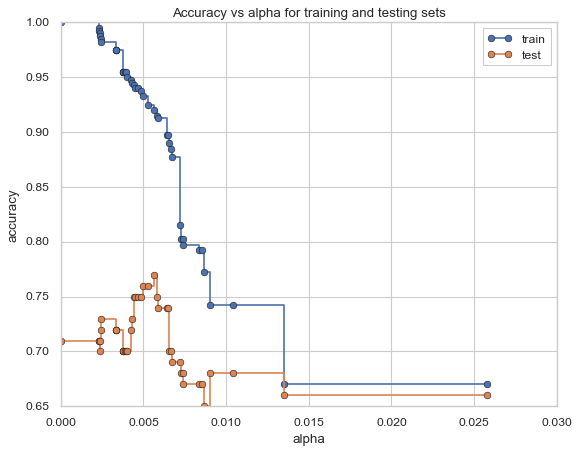

In [534]:
train_scores = [clf_dt.score(X_train, y_train) for clf_dt in clf_dts]
test_scores = [clf_dt.score(X_test, y_test) for clf_dt in clf_dts]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker="o", label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker="o", label="test", drawstyle="steps-post")
ax.legend()
plt.show()

In the graph above, we see that the accuracy for the **Testing Dataset** hits its maximum value when `alpha` is about **0.014**. After this value for `alpha`, the accuracy of the **Training Dataset** drops off and that suggests we should set `ccp_alpha=0.014`.

#### Decision tree pruning.

In [535]:
## Build and train a new decision tree, only this time use the optimal value for alpha
clf_dt_pruned = DecisionTreeClassifier(random_state=42, ccp_alpha=0.014)
clf_dt_pruned = clf_dt_pruned.fit(X_train, y_train)

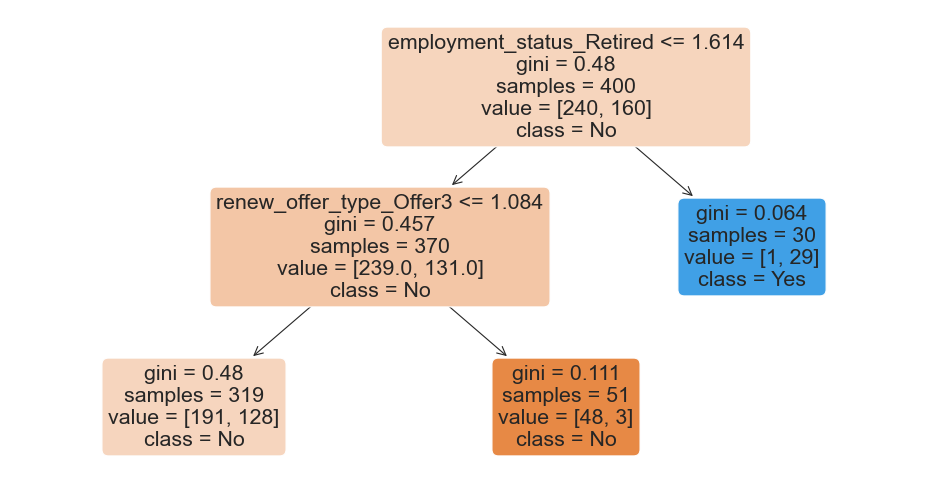

In [536]:
plt.figure(figsize=(15, 7.5))
plot_tree(
    clf_dt_pruned,
    filled=True,
    rounded=True,
    class_names=["No", "Yes"],
    feature_names=X_predictors.columns,
);

In [537]:
los_preds_old = clf_dt_pruned.predict(X_train)
los_preds_new = clf_dt_pruned.predict(X_test)

--------------------------------------
DecisionTree-Pruned-Traininig::ConfusionMatrix and ROC-AUC Curve
--------------------------------------


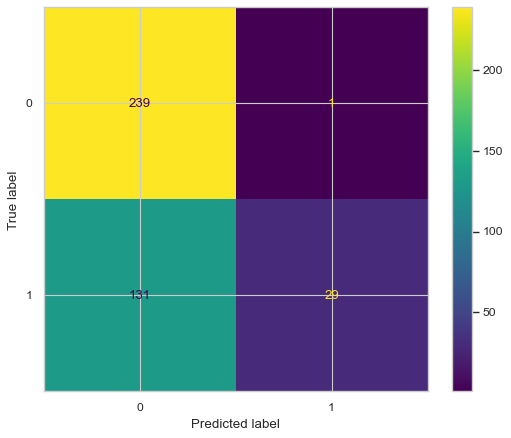

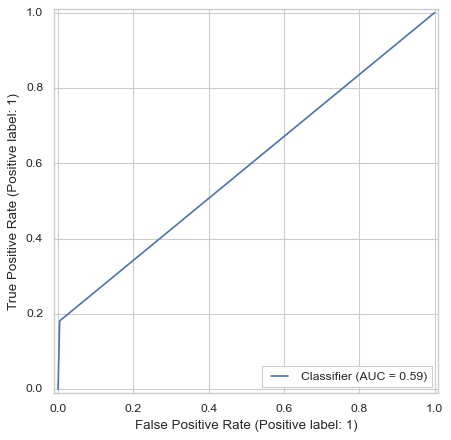

,Accuracy,ROC-AUC,F1-Score,Precision,Recall
DecisionTree-Pruned-Traininig:,0.67,0.58854,0.30526,0.96667,0.18125


In [538]:
custom_classification_metrics_report("DecisionTree-Pruned-Traininig:", y_train, los_preds_old)

--------------------------------------
DecisionTree-Pruned:Testing:ConfusionMatrix and ROC-AUC Curve
--------------------------------------


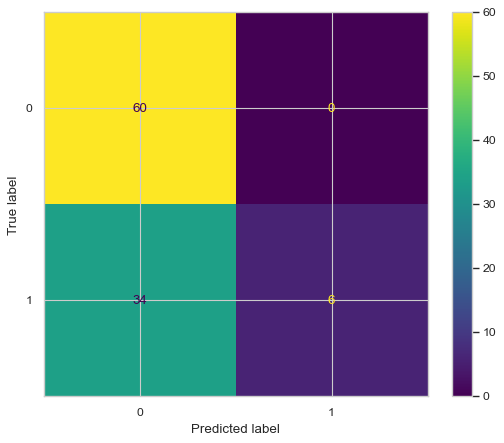

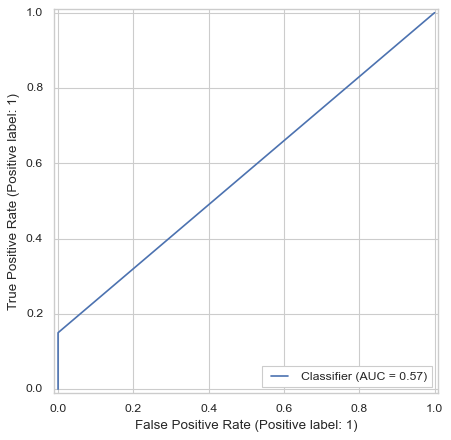

,Accuracy,ROC-AUC,F1-Score,Precision,Recall
DecisionTree-Pruned:Testing,0.66,0.575,0.26087,1.0,0.15


In [539]:
custom_classification_metrics_report("DecisionTree-Pruned:Testing", y_test, los_preds_new)

#### RandomForest-Classification

In [540]:
# Define the parameter grid
param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [5, 8, 10],
    # 'min_samples_split': [2, 5, 10, 15],
    # 'min_samples_leaf': [1, 2, 4, 8],
    "max_features": [int(np.sqrt(50) * 0.75), int(np.sqrt(50))],
}

# Create the random forest classifier
rf = RandomForestClassifier()

grid_search = GridSearchCV(
    rf, param_grid, cv=5, scoring="accuracy"
) 

# Fit the grid search to your data
grid_search.fit(X_train, y_train)  # Replace X_train and y_train with your training data

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [5, 8, 10], 'max_features': [5, 7],
                         'n_estimators': [100, 200]},
             scoring='accuracy')

In [541]:
grid_search.best_params_

{'max_depth': 8, 'max_features': 7, 'n_estimators': 100}

In [542]:
## create a decisiont tree and fit it to the training data
_model_RF_C_tuned = RandomForestClassifier(
    max_depth=10, max_features=7, n_estimators=100, random_state=2024
)

In [543]:
_model_RF_C_tuned.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, max_features=7, random_state=2024)

In [544]:
los_tr_preds_C_tuned = _model_RF_C_tuned.predict(X_train)
los_tes_preds_C_tuned = _model_RF_C_tuned.predict(X_test)

--------------------------------------
Baggin-Training:ConfusionMatrix and ROC-AUC Curve
--------------------------------------


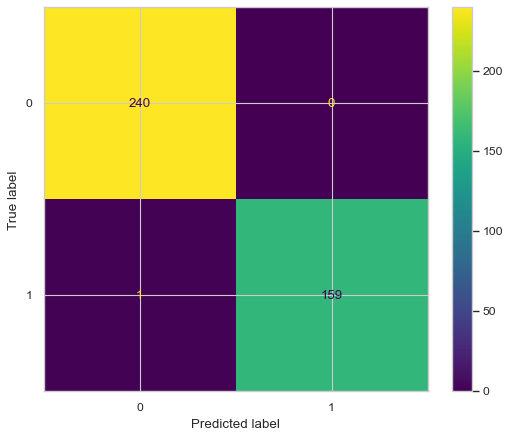

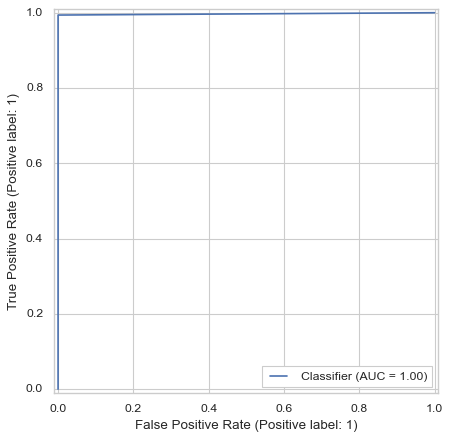

,Accuracy,ROC-AUC,F1-Score,Precision,Recall
Baggin-Training,0.9975,0.99688,0.99687,1.0,0.99375


In [545]:
custom_classification_metrics_report("Baggin-Training", y_train, los_tr_preds_C_tuned)

--------------------------------------
Bagging-Testing:ConfusionMatrix and ROC-AUC Curve
--------------------------------------


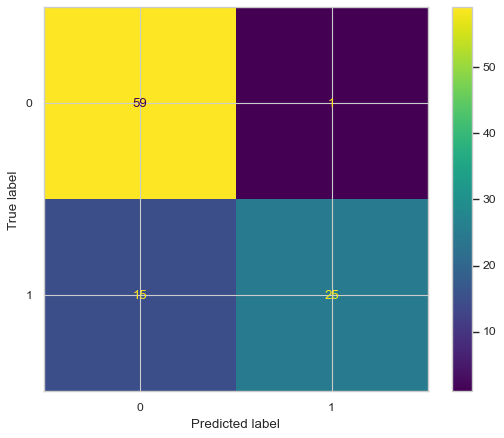

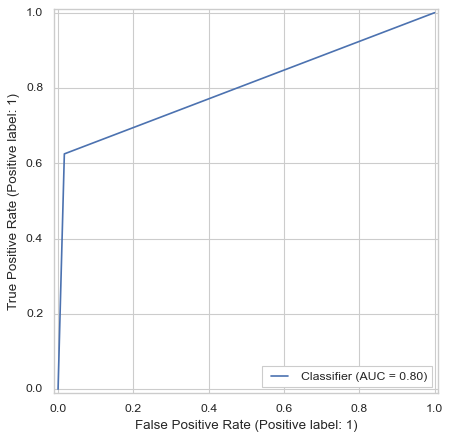

,Accuracy,ROC-AUC,F1-Score,Precision,Recall
Bagging-Testing,0.84,0.80417,0.75758,0.96154,0.625


In [546]:
custom_classification_metrics_report("Bagging-Testing", y_test, los_tes_preds_C_tuned)

#### XGB-Classification

In [547]:
param_grid = {
    'n_estimators': hp.quniform('n_estimators', 200, 2500, 100),
    'max_depth': hp.quniform('max_depth', 1, 10, 1),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.001), np.log(1)),
    'booster': hp.choice('booster', ['gbtree', 'dart']),
    'gamma': hp.loguniform('gamma', np.log(0.01), np.log(10)),
    'subsample': hp.uniform('subsample', 0.50, 0.90),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.50, 0.99),
    'colsample_bylevel': hp.uniform('colsample_bylevel', 0.50, 0.99),
    'colsample_bynode': hp.uniform('colsample_bynode', 0.50, 0.99),
    'reg_lambda': hp.uniform('reg_lambda', 1, 20)
}

# the objective function takes the hyperparameter space
# as input

def objective(params):

    # we need a dictionary to indicate which value from the space
    # to attribute to each value of the hyperparameter in the xgb
    params_dict = {
        # important int, as it takes integers only
        'n_estimators': int(params['n_estimators']),
        # important int, as it takes integers only
        'max_depth': int(params['max_depth']),
        'learning_rate': params['learning_rate'],
        'booster': params['booster'],
        'gamma': params['gamma'],
        'subsample': params['subsample'],
        'colsample_bytree': params['colsample_bytree'],
        'colsample_bylevel': params['colsample_bylevel'],
        'colsample_bynode': params['colsample_bynode'],
        'random_state': 1000,
    }

    # with ** we pass the items in the dictionary as parameters
    # to the xgb
    gbm = xgb.XGBClassifier(**params_dict)

    # train with cv
    score = cross_val_score(gbm, X_train, y_train,
                            scoring='accuracy', cv=3, n_jobs=4).mean()

    # to minimize, we negate the score
    return -score

In [548]:
# fmin performs the minimization
# rand.suggest samples the parameters at random
# i.e., performs the random search

random_search = fmin(
    fn=objective,
    space=param_grid,
    max_evals=1,
    rstate=np.random.default_rng(2024),
    algo=rand.suggest,  # randomized search
)

100%|██████████| 1/1 [00:18<00:00, 18.16s/trial, best loss: -0.6674148056708936]


In [549]:
random_search

{'booster': 1,
 'colsample_bylevel': 0.546007358061281,
 'colsample_bynode': 0.5187931176469971,
 'colsample_bytree': 0.7322586366977841,
 'gamma': 8.110007681126655,
 'learning_rate': 0.021701657654466605,
 'max_depth': 3.0,
 'n_estimators': 300.0,
 'reg_lambda': 9.465235229189696,
 'subsample': 0.6343753989670202}

In [550]:
_XGB_CLS_spec_tuned = xgb.XGBClassifier(
    objective="binary:logistic",
    booster='dart',
    gamma=8.11,
    learning_rate=0.02,
    max_depth=3,
    n_estimators=300,
    reg_lambda=9.46,
    subsample=0.63,
    colsample_bylevel=0.5,
    colsample_bynode=0.5,
    colsample_bytree=0.7,
)

In [551]:
_XGB_CLS_spec_tuned.fit(X_train,y_train)

XGBClassifier(base_score=None, booster='dart', callbacks=None,
              colsample_bylevel=0.5, colsample_bynode=0.5, colsample_bytree=0.7,
              device=None, early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=8.11,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.02, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [552]:
los_tr_preds_xgb_tuned = _XGB_CLS_spec_tuned.predict(X_train)
los_tes_preds_xgb_tuned = _XGB_CLS_spec_tuned.predict(X_test)

--------------------------------------
Boosting-Training:ConfusionMatrix and ROC-AUC Curve
--------------------------------------


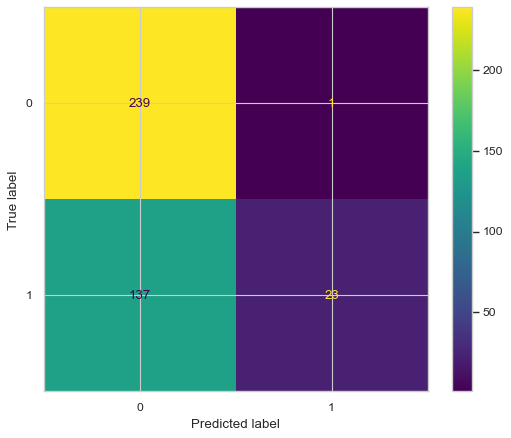

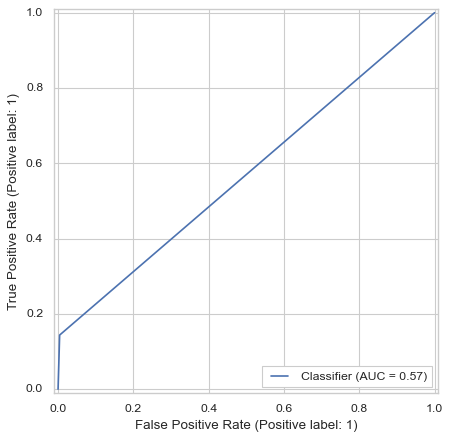

,Accuracy,ROC-AUC,F1-Score,Precision,Recall
Boosting-Training,0.655,0.56979,0.25,0.95833,0.14375


In [553]:
custom_classification_metrics_report("Boosting-Training", y_train, los_tr_preds_xgb_tuned)

--------------------------------------
Boosting-Testing:ConfusionMatrix and ROC-AUC Curve
--------------------------------------


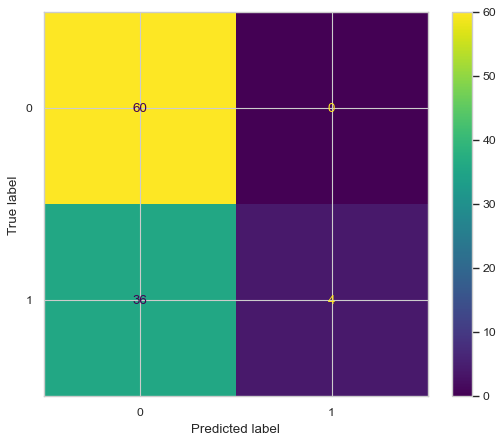

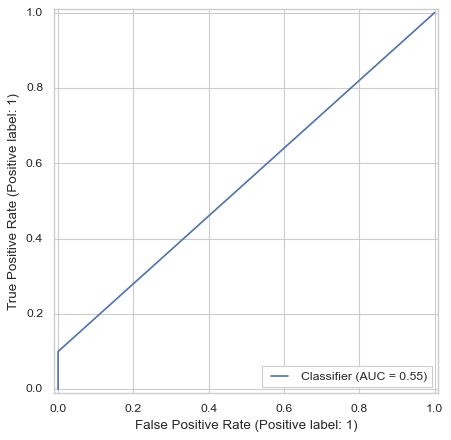

,Accuracy,ROC-AUC,F1-Score,Precision,Recall
Boosting-Testing,0.64,0.55,0.18182,1.0,0.1


In [554]:
custom_classification_metrics_report("Boosting-Testing", y_test, los_tes_preds_xgb_tuned)

### Classification ModelSummary

|model|training-Accuracy|testing-Accuracy|
|----|----------|------|
|LogisticRegression|0.76|0.72|
|Tree|0.67|0.66|
|Bagging|0.99|0.84|
|Boosting|0.65|0.64|


**1. Logistic Regression:** This model achieved a good training accuracy of 76% but dropped slightly to 72% on testing data. This indicates a reasonable fit on the training data but suggests some room for improvement in generalizing to unseen data.

**2.Tree:** This model has a lower training accuracy (67%) compared to Logistic Regression. Its testing accuracy is also lower (66%) suggesting it might not be capturing the underlying patterns in the data as effectively.

**3.Bagging:** This model shows a very high training accuracy (99%). However, the testing accuracy drops significantly to 84%. This is a classic sign of overfitting. The model memorized the training data too well and performs poorly on unseen data.

**4.Boosting:** This model has the lowest training accuracy (65%) among all. However, its testing accuracy is similar (64%). This suggests the model might not be the most accurate but it generalizes reasonably well to unseen data.

**In a conclusion**
- Logistic Regression seems like a balanced choice with decent performance on both training and testing data.

- Tree might need further exploration or tuning to improve its accuracy.

- Bagging suffers from severe overfitting and should not be used without further adjustments.

- Boosting, despite lower training accuracy, generalizes well and could be a good option depending on the specific needs.

### Suggest an optimal model (s) for predicting the CLF and Discontinuance.

- XGBoost Regressor proved to be the most effective model for predicting the continuous CLF target variable. Additionally, XGBoost Classifier emerged as the best model for classifying customer churn, meaning it can best predict whether a customer will discontinue their service or not.